# Waveform Similairty
This will download seismic waveforms & measure waveform similarity between two data. ObsPy, numpy, scipy, matplotlib are required.

## Import ObsPy module

In [1]:
from obspy import read
from obspy import UTCDateTime
from obspy import read, read_inventory

from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth

from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.rotate import rotate_rt_ne
from obspy.signal.rotate import rotate2zne



import obspy as ob
print("# obspy version = ",ob.__version__)

# obspy version =  1.2.2


## Import SciPy, NumPy, matplotlib module

In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl

print("# numpy version = ",np.__version__)
print("# scipy version = ",sp.__version__)
print("# matplotlib version = ",mpl.__version__)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates 

from scipy.fftpack import fft, ifft
from scipy.linalg import norm
from scipy import ndimage
from scipy import signal
from scipy.stats import pearsonr

import sys
import os


# numpy version =  1.19.1
# scipy version =  1.5.2
# matplotlib version =  3.3.1


## Font size

In [3]:
# font size
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#SMALL_SIZE = 32
#MEDIUM_SIZE = 32
#BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## function: get_seedid
to extract seed_id from obspy stream.

In [4]:
def get_seedid (tr):
    seedid=tr.stats.network+"."+tr.stats.station+"."+tr.stats.location+"."+tr.stats.channel
    return seedid

## function: st_remove_resp
to correct instrument response.

In [5]:
def st_remove_resp_inv (st, deciopt, decifactor, pre_filt, output, inv):
    st.detrend("linear") # remove linear trend
    st.detrend("demean") # demean
    st.taper(0.05) # cosin taper

    if deciopt == 1:
        # decimate to 100Hz
        if decifactor == 100:     
            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

        else:
            st.decimate(factor=decifactor, strict_length=False)
    print(inv)
    st = st.remove_response(pre_filt=pre_filt,output=output,water_level=None, inventory=inv) # get velocity data (m/s)

    return st


In [6]:
def st_remove_resp (st, deciopt, decifactor, pre_filt, output):
    st.detrend("linear") # remove linear trend
    st.detrend("demean") # demean
    st.taper(0.05) # cosin taper

    if deciopt == 1:
        # decimate to 100Hz
        if decifactor == 100:     
            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

        elif decifactor == 200:     
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

        elif decifactor == 500:     
            st.decimate(5, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)
        else:
            st.decimate(factor=decifactor, strict_length=False)
    
    st = st.remove_response(pre_filt=pre_filt,output=output,water_level=None) # get velocity data (m/s)

    return st


## function: get_sta_coord
to extract station coordinate from obspy stream.

In [7]:
def get_sta_coord (seedid, inv, starttime):
    sta_coordinate = inv.get_coordinates(seedid, starttime)
    return sta_coordinate


## function: get_sta_orientation
to extract sensor orientation from obspy stream.

In [8]:
def get_sta_orientation (seedid, inv, starttime):
    sta_orientation = inv.get_orientation(seedid, starttime)
    return sta_orientation


## function: get_zne_data
to rotate 3-com data into ZNE coordinate

In [9]:
def get_zne_data (st, inv, starttime):

    st_len = len(st)
    
    if st_len != 3:
        print("# cannot do!")
        

    sta_coordinate = []
    sta_orientation = []

    #for tr in st1:
    for i, tr in enumerate(st, 1):
        #print("# i = ",i)
        seedid=get_seedid(tr)
        #sta_coordinate[i] = get_sta_coord(tr, seedid, inv1, starttime)

        sta_coordinate.append(get_sta_coord(seedid, inv, starttime))
        sta_orientation.append(get_sta_orientation(seedid, inv, starttime))

        print("# seedid = ",seedid, sta_coordinate)
        print("# seedid = ",seedid, sta_orientation)

    print("# st2 = ",st[2])
    print("# st1 = ",st[1])
    print("# st0 = ",st[0])
    ztmp = st[2]
    AzZ = sta_orientation[2]['azimuth']
    DipZ = sta_orientation[2]['dip']
    
    ntmp = st[1]
    AzN = sta_orientation[1]['azimuth']
    DipN = sta_orientation[1]['dip']

    etmp = st[0]
    AzE = sta_orientation[0]['azimuth']
    DipE = sta_orientation[0]['dip']
    
    
    # test
    #AzN = 35.0
    #AzE = 125.0
    
    
    print("# AzZ = ", AzZ, " DipZ = ", DipZ)
    print("# AzN = ", AzN, " DipN = ", DipN)
    print("# AzE = ", AzE, " DipE = ", DipE)

    
    t1z , t1n, t1e = rotate2zne(ztmp,AzZ,DipZ,ntmp,AzN,DipN,etmp,AzE,DipE)
    st[0].data = t1e
    st[1].data = t1n
    st[2].data = t1z
    #i_1.stats.channel[:-1] + \
    #                output_components[0]
    st[0].stats.channel = st[0].stats.channel[:-1] + "E"
    st[1].stats.channel = st[0].stats.channel[:-1] + "N"
    st[2].stats.channel = st[0].stats.channel[:-1] + "Z"

    return st


## function: get_baz
to compuete back-azimuth

In [10]:
def get_baz (st, inv, evla, evlo):
    seedid=get_seedid(st[0])
    sta_coord = get_sta_coord(seedid,inv,starttime)
    
    stla = sta_coord['latitude']
    stlo = sta_coord['longitude']
    
    source_latitude = evla
    source_longitude = evlo
    
    station_latitude = stla
    station_longitude = stlo
    
    # theoretical backazimuth and distance
    baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

    print('Epicentral distance [m]: ', baz[0])
    print('Epicentral distance [km]: ', baz[0]/1000.0)
    print('Theoretical azimuth [deg]: ', baz[1])
    print('Theoretical backazimuth [deg]: ', baz[2])
    
    return baz

In [11]:
plotOPT = 0 # no plot#
plotOPT = 1 # plot


## function: waveform_comparison
will add coherency later

In [12]:
def waveform_comparison (st, plotOPT, slideOPT, logOPT, manualOPT):
    
    #plt.switch_backend('Agg')
    
    sncl1 = get_seedid(st[0])
    sncl2 = get_seedid(st[1])
    #print("# sncl1 = ", sncl1)
    #print("# sncl2 = ", sncl2)
    # def
    # slide
    if slideOPT:
        plot_fi = plot_dir+"/"+sncl2+"_"+sncl1+"_"+event_para+".png"
    else:
        plot_fi = plot_dir+"/"+sncl2+"_"+sncl1+"_"+event_para+".pdf"

    #print("# plot_fi = ",plot_fi)

    #print("# fft 0")

    T1=st[0].stats.delta
    N1=st[0].stats.npts
    xf1 = np.linspace(0.0, 1.0/(2.0*T1), N1//2)
    yf1 = fft(st[0].data)

    #print("# fft 1")

    T2=st[1].stats.delta
    N2=st[1].stats.npts
    xf2 = np.linspace(0.0, 1.0/(2.0*T2), N2//2)
    yf2 = fft(st[1].data)

    
    # correlation
    cc_pearsonr, p_pearsonr = pearsonr(st[0].data, st[1].data)
    cc_pearsonr_out = "{:.3f}".format(cc_pearsonr)
    print("#RESULT cc_pearsonr_out = ",cc_pearsonr_out," ",sncl1," ",sncl2)

    distkm1_out = "{:.3f}".format(baz1[0]/1000.0)
    distkm2_out = "{:.3f}".format(baz2[0]/1000.0)
    print("#RESULT distkm1_out = ",distkm1_out," ",sncl1," ",sncl2)
    print("#RESULT distkm2_out = ",distkm2_out," ",sncl1," ",sncl2)

    yf1_amp =  2.0/N1 * np.abs(yf1)
    yf2_amp =  2.0/N2 * np.abs(yf2)
    
    # no div N1 or N2 match sac results....
    yf1_amp =  2.0/1.0 * np.abs(yf1)
    yf2_amp =  2.0/1.0 * np.abs(yf2)
    
    index_select = np.where(  (fl <= xf2) & (xf2 <= fh) )
    #yf1_amp_max = np.amax(yf1_amp[index_select])
    #yf2_amp_max = np.amax(yf2_amp[index_select])
    #print("# yf1_amp_max = ", yf1_amp_max)
    #print("# yf2_amp_max = ", yf2_amp_max)
    yf_amp_max =  np.amax(np.concatenate((yf1_amp[index_select], yf2_amp[index_select]) ))
    #print("# yf_amp_max = ", yf_amp_max)
    yf_amp_min =  np.amin(np.concatenate((yf1_amp[index_select], yf2_amp[index_select]) ))
    #print("# yf_amp_min = ", yf_amp_min)
    yf_amp_max2 = yf_amp_max * 5
    yf_amp_min2 = yf_amp_min * 0.5

    #set amfactor = 5
    #set samaxIn = `cat depmax.out | grep depmax | awk '{print $3+0}' | head -1 | awk -v amfactor=$amfactor '{val=$1*amfactor; printf("%e\n",val); }' `
    #set saminIn = `echo $samaxIn | awk '{val=$1*-1; printf("%e\n",val); }' `
    #set amfactor = 0.5
    #set saminIn = `cat depmin.out | grep depmin | awk '{print $3+0}' | tail -1 | awk -v amfactor=$amfactor '{val=$1*amfactor; printf("%e\n",val); }' `


    yf_amp_ratio = yf2_amp / yf1_amp

    #print(np.where(a < 4, -1, a))

    #index200 = np.where( (190 <= periods) & (periods <= 210) )

    #index_select_num = index_select.shape
    #print("# index_select = ", index_select)         
    index_select_num = yf_amp_ratio[index_select].shape[0]
    #print("# index_select_num = ", index_select_num)

    #print("# yf_amp_ratio[index_select] = ", yf_amp_ratio[index_select])
    amp_median = ndimage.median(yf_amp_ratio[index_select])
    amp_l1 = norm(yf_amp_ratio[index_select]-amp_median, 1)/index_select_num

    #print("# amp_median = ",amp_median," amp_l1 = ", amp_l1)
    amp_l1_out = "{:.3f}".format(amp_l1)
    amp_median_out = "{:.3f}".format(amp_median)

    print("#RESULT amp_median_out = ",amp_median_out," amp_l1_out = ",amp_l1_out," ",sncl1," ",sncl2)

    yf1_ph = np.angle(yf1)
    yf2_ph = np.angle(yf2)
    
    
    yf1_ph = np.where(yf1_ph <= -np.pi,  yf1_ph + 2*np.pi,  yf1_ph)
    yf1_ph = np.where (np.pi <= yf1_ph,  yf1_ph - 2*np.pi,  yf1_ph)

    yf2_ph = np.where(yf2_ph <= -np.pi,  yf2_ph + 2*np.pi,  yf2_ph)
    yf2_ph = np.where (np.pi <= yf2_ph,  yf2_ph - 2*np.pi,  yf2_ph)

    yf_ph_diff = yf2_ph - yf1_ph

  
    # phase diff also. need to check it later
    #print("#  yf_ph_diff[index_select] = ",  yf_ph_diff[index_select])
    #print("# max = ",np.amax(yf_ph_diff[index_select]))
    yf_ph_diff = np.where(yf_ph_diff <= -np.pi,  yf_ph_diff + 2*np.pi,  yf_ph_diff)
    yf_ph_diff = np.where (np.pi <= yf_ph_diff,  yf_ph_diff - 2*np.pi,  yf_ph_diff)
    #print("#  yf_ph_diff[index_select] = ",  yf_ph_diff[index_select])
    #print("# max = ",np.amax(yf_ph_diff[index_select]))
    
    ph_median = ndimage.median(yf_ph_diff[index_select])
    ph_l1 = norm(yf_ph_diff[index_select]-ph_median, 1)/index_select_num
    
    #print("# ph_median = ",ph_median," ph_l1 = ", ph_l1)
    ph_l1_out = "{:.3f}".format(ph_l1)
    ph_median_out = "{:.3f}".format(ph_median)
    print("#RESULT ph_median_out = ",ph_median_out," ph_l1_out = ", ph_l1_out, " ",sncl1, " ", sncl2)


    print("#RESULT2 ",sncl1," ",sncl2," ",amp_median_out," ",amp_l1_out," ",ph_median_out," ",ph_l1_out," ",cc_pearsonr_out)


    #echo "# wmaxIn & wminIn are overwritted!"
    #set wmaxIn = `cat depmax.out | grep depmax | awk '{print $3+0}' | head -1 | awk -v amfactor=$amfactor '{val=$1*amfactor; printf("%e\n",val); }' `
    #set wminIn = `echo $wmaxIn | awk '{val=$1*-1; printf("%e\n",val); }' `
    #echo "# wminIn = "$wminIn" wmaxIn = "$wmaxIn

    yf_amp_max =  np.amax(np.concatenate((yf1_amp[index_select], yf2_amp[index_select]) ))

    data_all = np.concatenate((st[0].data, st[1].data) )
    wf_amp_max = max(data_all.min(), data_all.max(), key=abs)
    #print("# wf_amp_max = ", wf_amp_max)
    wf_amp_max2 = wf_amp_max * 1.1
    wf_amp_min2 = wf_amp_max2 * -1
    
    if plotOPT: 
        #plt.rcParams['figure.figsize'] = 16, 16

        #print("# plot")

        gs = gridspec.GridSpec(3,2)
        #gs = gridspec.GridSpec(6,2)

        #fig = plt.figure()

        # slide
        if slideOPT:
            fig = plt.figure(figsize=(28, 11.5))
            plt.subplots_adjust(wspace=0.15, hspace=0.45)
            #plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
            #plt.subplots_adjust(left=0.1, right=0.2)
    
        else:
            # def
            fig = plt.figure(figsize=(16, 16))
            plt.subplots_adjust(wspace=0.4, hspace=0.4)

        #fig.text(0.41, 0.3, 'leftbottom4',ha='right')
        #fig.text(0.42, 0.3, 'leftbottom5',ha='right')
        #fig.text(0.34, 0.3, 'leftbottom6',ha='right')

        t=fig.text(0.13, 0.85, str(fl)+"-"+str(fh)+" Hz BP filter")
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
        t=fig.text(0.13, 0.70, "CC = "+str(cc_pearsonr_out))
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

        if slideOPT:
            t=fig.text(0.48, 0.295, "Median: "+str(amp_median_out), ha='right')
            t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
            t=fig.text(0.48, 0.275, "L1 norm: "+str(amp_l1_out), ha='right')
            t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
        else:
            t=fig.text(0.44, 0.295, "Median: "+str(amp_median_out), ha='right')
            t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
            t=fig.text(0.44, 0.275, "L1 norm: "+str(amp_l1_out), ha='right')
            t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

        t=fig.text(0.89, 0.160, "Median: "+str(ph_median_out), ha='right')
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
        t=fig.text(0.89, 0.140, "L1 norm: "+str(ph_l1_out), ha='right')
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

        
        #fig.text(1, 0, 'rightbottom', ha='right')
        #fig.text(0, 1, 'lefttop', va='top')
        #fig.text(1, 1, 'righttop', ha='right', va='top')
        #print("# plot sub 1")

        ### waveforms 
        #plt.subplot(211)
        plt.subplot(gs[0, :])
        #plt.plot(st[0].times("matplotlib"), st[0].data*1,label=sncl1, color="red", linewidth=0.75)
        #plt.xaxis_date()
        plt.plot_date(st[0].times("matplotlib"), st[0].data*1, fmt='-', label=sncl1, color="red",  linewidth=0.75, linestyle='solid')
        plt.plot_date(st[1].times("matplotlib"), st[1].data*1, fmt='-', label=sncl2, color="blue", linewidth=0.75, linestyle='solid')

        myFmt = mdates.DateFormatter("%D/%H:%M") 
        #mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S")
        myFmt = mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S") 
        plt.gca().xaxis.set_major_formatter(myFmt) 


        plt.xlim(st[0].times("matplotlib")[0], st[0].times("matplotlib")[-1])
        plt.ylim(wf_amp_min2 , wf_amp_max2 )
        plt.grid()

        #plt.title("Waveform comparison")
        #
        #Mw:7.8 ALASKA-PENINSULA
        #plt.title("Origin Time:2020-07-22T06:12:44 IRIS event-id:11273635 \n Mw:7.8 ALASKA-PENINSULA ")
        if manualOPT:
            print("# no title")
        else:
            plt.title(event_para+" \n Origin Time:"+str(origin_time)+" USGS event-id:"+evid+" \n M"+str(evmag)+" "+event_region)

        #plt.text(0.1, 0.9,'matplotlib', ha='center', va='center') 
        #plt.text(x, y, s, bbox=dict(facecolor='red', alpha=0.5))
        
        #plt_pos = plt.get_position()
        #fig = plt.figure()
        #ax = plt.axes()
        #txt = plt.text(0.1,0.5,"My text", transform = ax.transAxes)
        #txt = plt.text(0.1,0.5,"My text")

        plt.ylabel("Amplitude (m/s)")
        #plt.xlabel("Time")
        plt.legend(loc = "upper right")
        #plt.legend(loc="upper left")
        ### waveforms 
        
        ### amplitude spectra
        #plt.subplot(313)
        plt.subplot(gs[1,0])
        #print("# plot sub 2")

        plt.plot(xf1, (yf1_amp[0:N1//2]), label=sncl1, color="red", linewidth=0.75)
        plt.plot(xf2, (yf2_amp[0:N2//2]), label=sncl2, color="blue", linewidth=0.75)
        plt.xlim(fl,fh)
        plt.ylim(yf_amp_min2, yf_amp_max2)
        plt.grid()
        #plt.rc('axes.formatter', useoffset=False)
        #plset_major_formatter(mticker.ScalarFormatter()) 
        #ax.ticklabel_format(useOffset=False, style='plain')
        #matplotlib.pyplot.ticklabel_format(*, axis='both', style='', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
        #plt.ticklabel_format(useOffset=False, style='plain')
        
        #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        #plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
        
        plt.yscale("log")
        if logOPT:
            plt.xscale("log")
            
        #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        #plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
        
        plt.title("Amplitude spectra")
        plt.ylabel("Amplitude (m$^2$/s$^2$/Hz)")
        plt.xlabel("Frequency (Hz)")
        plt.legend(loc = "upper right")
        ### amplitude spectra

        ### phase spectra
        plt.subplot(gs[1,1])
        #print("# plot sub 3")

        plt.plot(xf1, (yf1_ph[0:N1//2]), label=sncl1, color="red", linewidth=0.75)
        plt.plot(xf2, (yf2_ph[0:N2//2]), label=sncl2, color="blue", linewidth=0.75)
        
        plt.xlim(fl,fh)
        plt.ylim(-4,4)
        plt.grid()

        #plt.yscale("log")
        if logOPT:
            plt.xscale("log")
            
        plt.title("Phase spectra")
        plt.ylabel("Phase (rad)")
        plt.xlabel("Frequency (Hz)")
        plt.legend(loc = "upper right")     
        ### phase spectra
        
        ### amplitude ratio
        plt.subplot(gs[2,0])
        #print("# plot sub 4")

        
        plt.plot(xf1, (yf_amp_ratio[0:N1//2]), color="black", linewidth=0.75)
        plt.plot([fl, fh], [amp_median, amp_median], color="black", linewidth=1.25, linestyle="dashed")

        plt.xlim(fl,fh)
        plt.ylim(0.5,1.5)
        plt.grid()

        #plt.yscale("log")
        if logOPT:
            plt.xscale("log")

        plt.title("Spectral amplitude ratio")
        # def
        #plt.ylabel("Amp. ("+sncl2+"/"+sncl1+")")     
        # slide
        plt.ylabel("Amp. ("+sncl2+"/\n"+sncl1+")")       

        plt.xlabel("Frequency (Hz)")


        #plt.legend()
        ### amplitude ratio
        
        ### phase diff
        plt.subplot(gs[2,1])
        #print("# plot sub 5")

        plt.plot(xf1, (yf_ph_diff[0:N1//2]), color="black", linewidth=0.75)
        #plt.plot(xf1, (yf_ph_diff[0:N1//2])/(2*np.pi*xf1), color="red", linewidth=0.75)
        delay_sec = (yf_ph_diff[0:N1//2])/(2*np.pi*xf1)
        #print("# delay_sec = ", delay_sec)
        st[0].delay_sec = delay_sec
        st[0].xf1 = xf1
        plt.plot([fl, fh], [ph_median, ph_median], color="black", linewidth=1.25, linestyle="dashed")

        plt.xlim(fl,fh)
        plt.ylim(-1.0,1.0)
        #plt.ylim(-7.0,7.0)
        plt.grid()

        #plt.yscale("log")
        if logOPT:
            plt.xscale("log")


        plt.title("Difference in spectral phase")
        # def
        #plt.ylabel("Phase ("+sncl2+"-"+sncl1+")")
        # slide
        plt.ylabel("Phase ("+sncl2+"-\n"+sncl1+")")

        plt.xlabel("Frequency (Hz)")
        #plt.legend()
        ### phase diff
        
        # def
        #plt.savefig(plot_fi) 
        # slide
        plt.savefig(plot_fi, bbox_inches="tight")



## Set client (Data Center) for event search
This example uses USGS. We can use other dataceneter (e.g., NCEDC, IRIS)

In [13]:
#clientEQ = Client("IRIS")
clientEQ = Client("USGS")


## Event search
Set time window (st, et) and a range of magunitude (minmag, maxmag). This example will find the 22 July 2020 M 7.8 Alaska event.

1 Event(s) in Catalog:
2022-01-14T09:05:42.540000Z |  -6.929, +105.251 | 6.6 mww | manual


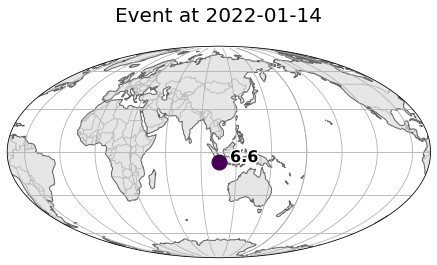

In [14]:
#M 7.8 - Alaska Peninsula
#2020-07-22 06:12:44 (UTC)55.068°N 158.554°W28.0 km depth
#https://earthquake.usgs.gov/earthquakes/eventpage/us7000asvb/executive
st = UTCDateTime("2020-07-22T00:00:00")  # 
et = UTCDateTime("2020-07-23T00:00:00")  #
minmag = 7.0
maxmag = 9.9

#M 2.2 - 10km ESE of Livermore, CA
#2020-09-15 11:02:22 (UTC)37.646°N 121.660°W1.4 km depth
st = UTCDateTime("2020-09-15T11:02:00")  # 
et = UTCDateTime("2020-09-15T11:03:00")  #
minmag = 2.0
maxmag = 2.5   
#M 4.2 - 28 km SSE of Mina, Nevada
#2020-09-15 16:33:36 (UTC)38.160°N 117.962°W11.6 km depth
#st = UTCDateTime("2020-09-15T16:33:00")  # 
#et = UTCDateTime("2020-09-15T16:34:00")  #
#minmag = 4.0
#maxmag = 4.5


#M 8.6 - off the west coast of northern Sumatra
#2012-04-11 08:38:36 (UTC)2.327°N 93.063°E20.0 km depth
#st = UTCDateTime("2012-04-11T08:30:00")  # 
#et = UTCDateTime("2012-04-11T08:40:00")  #
#minmag = 8.5
#maxmag = 8.8    


#M 2.6 - 1km SSW of Pleasant Hill, CA
#2019-10-15 06:55:05 (UTC)37.937°N 122.065°W12.5 km depth
st = UTCDateTime("2019-10-15T06:00:00")  # 
et = UTCDateTime("2019-10-15T08:00:00")  #
minmag = 2.5
maxmag = 3.0   
#M 4.4 - 3km ENE of Westmorland, CA
#2020-09-30 23:31:52 (UTC)33.051°N 115.590°W7.5 km depth
st = UTCDateTime("2020-09-30T23:30:00")  # 
et = UTCDateTime("2020-09-30T23:32:00")  #
minmag = 4.3
maxmag = 4.5       
#M 4.9 - 4km NE of Westmorland, CA
#2020-10-01 00:31:27 (UTC)33.056°N 115.590°W11.5 km depth
st = UTCDateTime("2020-10-01T00:30:00")  # 
et = UTCDateTime("2020-10-01T00:32:00")  #
minmag = 4.3
maxmag = 5.0


#M 3.3 - 12km E of Ridgecrest, CA
#2020-10-02 12:32:47 (UTC)35.641°N 117.548°W4.7 km depth
st = UTCDateTime("2020-10-02T12:30:00")  # 
et = UTCDateTime("2020-10-02T12:33:00")  #
minmag = 3.2
maxmag = 3.4       
#M 2.3 - 17km W of Searles Valley, CA
#2020-10-08 03:02:23 (UTC)35.767°N 117.589°W7.8 km depth
st = UTCDateTime("2020-10-08T03:02:00")  # 
et = UTCDateTime("2020-10-08T03:03:00")  #
minmag = 2.2
maxmag = 2.4           
#M 3.7 - 31km NNE of Redway, CA
#2020-10-10 01:24:11 (UTC)40.392°N 123.738°W23.4 km depth
st = UTCDateTime("2020-10-10T01:24:00")  # 
et = UTCDateTime("2020-10-10T01:25:00")  #
minmag = 3.6
maxmag = 3.8         



#M 3.9 - 1km NNE of The Geysers, CA
#2020-08-12 11:45:43 (UTC)38.787°N 122.749°W4.1 km depth
st = "2020-08-12T11:45:43"
et = "2020-08-12T11:48:43"          
minmag = 3.7
maxmag = 4.0

#M 3.7 - 30km NNE of Redway, CA
#2020-10-10 01:24:11 (UTC)40.376°N 123.733°W28.6 km depth
st = "2020-10-10T00:45:43"
et = "2020-10-10T01:48:43"          
minmag = 3.5
maxmag = 4.0

#M 2.6 - 4km SE of Larkfield-Wikiup, CA
#2020-09-08 08:56:50 (UTC)38.492°N 122.718°W6.8 km depth
st = "2020-09-08T08:55:43"
et = "2020-09-08T08:57:43"          
minmag = 2.4
maxmag = 2.7

#M 4.2 - 1km WSW of The Geysers, CA
#2019-11-03 20:34:57 (UTC)38.775°N 122.767°W3.1 km depth
st = "2019-11-03T20:30:43"
et = "2019-11-03T20:37:43"          
minmag = 3.4
maxmag = 4.2   

#M 3.6 - 10km ESE of Hidden Valley Lake, CA
#2019-08-23 14:16:52 (UTC)38.772°N 122.452°W10.2 km depth
st = "2019-08-23T14:12:43"
et = "2019-08-23T14:17:43"          
minmag = 3.4
maxmag = 4.2   

#M 2.7 - 3km ENE of The Geysers, CA
#2019-10-17 11:58:15 (UTC)38.790°N 122.727°W0.6 km depth
st = "2019-10-17T11:57:43"
et = "2019-10-17T11:59:43"          
minmag = 2.5
maxmag = 2.9

#M 2.8 - 4km SSW of Anderson Springs, CA
#2019-09-09 21:31:39 (UTC)38.741°N 122.721°W1.7 km depth
st = "2019-09-09T21:30:43"
et = "2019-09-09T21:32:43"          
minmag = 2.5
maxmag = 2.9       

#M 7.4 - 94 km SE of Sand Point, Alaska
#2020-10-19 20:54:40 (UTC)54.665°N 159.608°W41.0 km depth
st = "2020-10-19T20:30:43"
et = "2020-10-19T21:32:43"          
minmag = 7.3
maxmag = 7.6 

#M 4.4 - 102km W of Petrolia, CA
#2021-01-12 13:22:03 (UTC)40.426°N 125.478°W2.2 km depth
st = "2021-01-12T13:21:03"
et = "2021-01-12T13:23:03"          
minmag = 4.3
maxmag = 4.5
#M 4.0 - 41km NNE of Toms Place, CA
#2021-01-15 22:11:07 (UTC)37.913°N 118.540°W1.1 km depth
st = "2021-01-15T22:10:43"
et = "2021-01-15T22:11:43"  

minmag = 3.9
maxmag = 4.2

#M 2.8 - 10km SSE of San Juan Bautista, CA
#2021-01-13 08:26:31 (UTC)36.769°N 121.478°W4.8 km depth
st = "2021-01-13T08:25:43"
et = "2021-01-13T08:27:43" 

minmag = 2.7
maxmag = 2.9


#M 7.0 - 210 km SE of Pondaguitan, Philippines
#2021-01-21 12:23:05 (UTC)5.007°N 127.517°E95.8 km depth
st = "2021-01-21T12:22:05"
et = "2021-01-21T12:24:43"   

minmag = 6.5
maxmag = 7.2




#M 3.7 - 22km SSE of Lopez Point, CA
#2021-02-28 08:45:39 (UTC)35.842°N 121.453°W8.9 km depth
st = "2021-02-28T08:35:00"
et = "2021-02-28T08:55:00"   

minmag = 3.5
maxmag = 3.9
       
    
#M 2.5 - 9km SSW of Tres Pinos, CA
#2021-03-02 03:32:40 (UTC)36.716°N 121.348°W4.0 km depth
st = "2021-03-02T03:30:00"
et = "2021-03-02T03:35:00"   

minmag = 2.3
maxmag = 2.6
       

#M 8.1 - Kermadec Islands, New Zealand
#2021-03-04 19:28:31 (UTC)29.740°S 177.267°W19.4 km depth
st = UTCDateTime("2021-03-04T19:00:00")  # 
et = UTCDateTime("2021-03-04T20:00:00")  #
minmag = 7.0
maxmag = 9.9


#M 7.5 - southeast of the Loyalty Islands
#2021-02-10 13:20:00 (UTC)23.279°S 171.489°E10.0 km depth
st = "2021-02-10T13:15:00"
et = "2021-02-10T13:25:00"   

minmag = 7.0
maxmag = 7.8

#M 8.1 - Kermadec Islands, New Zealand
#2021-03-04 19:28:32 (UTC)29.735°S 177.282°W26.5 km depth
st = UTCDateTime("2021-03-04T19:20:00")  # 
et = UTCDateTime("2021-03-04T19:30:00")  #
minmag = 7.5
maxmag = 9.0   


#M 7.0 - 27 km ENE of Ishinomaki, Japan
#2021-03-20 09:09:45 (UTC)38.475°N 141.607°E54.0 km depth
st = UTCDateTime("2021-03-20T09:00:00")  # 
et = UTCDateTime("2021-03-20T09:10:00")  #
minmag = 6.9
maxmag = 7.2     



#M 4.0 - 21km SSW of Willits, CA
#2021-03-24 15:41:13 (UTC)39.245°N 123.474°W8.2 km depth
st = UTCDateTime("2021-03-24T15:35:00")  # 
et = UTCDateTime("2021-03-24T15:50:00")  #
minmag = 3.9
maxmag = 4.2  

#M 3.2 - 10km E of Gilroy, CA
#2021-03-24 23:07:08 (UTC)37.004°N 121.462°W8.3 km depth
st = UTCDateTime("2021-03-24T23:00:00")  # 
et = UTCDateTime("2021-03-24T23:10:00")  #
minmag = 3.1
maxmag = 3.3  


#M 2.3 - 7km E of San Ardo, CA
#2021-05-21 06:03:31 (UTC)36.029°N 120.824°W10.3 km depth
st = UTCDateTime("2021-05-21T06:03:31")  # 
et = UTCDateTime("2021-05-21T06:04:31")  #
minmag = 2.2
maxmag = 2.4

#M 7.3 - Southern Qinghai, China
#2021-05-21 18:04:13 (UTC)34.586°N 98.255°E10.0 km depth
st = UTCDateTime("2021-05-21T18:02:31")  # 
et = UTCDateTime("2021-05-21T18:05:31")  #
minmag = 7.2
maxmag = 7.4       

#M 5.4 - off the coast of Oregon
#2021-04-29 10:30:23 (UTC)43.833°N 128.036°W10.0 km depth
st = UTCDateTime("2021-04-29T10:29:31")  # 
et = UTCDateTime("2021-04-29T10:33:31")  #
minmag = 5.4
maxmag = 5.5       


#M 2.1 - 0km NE of Etna, CA
#2021-05-14 07:43:16 (UTC)41.460°N 122.892°W14.0 km depth
        
st = UTCDateTime("2021-05-14T07:42:31")  # 
et = UTCDateTime("2021-05-14T07:44:31")  #
minmag = 2.0
maxmag = 2.2       

#M 5.1 - 290 km W of Bandon, Oregon
#2021-02-20 21:15:53 (UTC)43.669°N 127.920°W10.0 km depth
st = UTCDateTime("2021-02-20T21:10:31")  # 
et = UTCDateTime("2021-02-20T21:20:31")  #
minmag = 5.0
maxmag = 5.2       

#M 4.0 - 20km ENE of Redway, CA
#2021-04-20 09:48:34 (UTC)40.188°N 123.599°W33.9 km depth
st = UTCDateTime("2021-04-20T09:48:31")  # 
et = UTCDateTime("2021-04-20T09:50:31")  #
minmag = 3.9
maxmag = 4.1      


#M 4.4 - 27km W of Petrolia, CA
#2021-04-02 08:21:35 (UTC)40.304°N 124.601°W19.1 km depth
st = UTCDateTime("2021-04-02T08:20:31")  # 
et = UTCDateTime("2021-04-02T08:22:31")  #
minmag = 4.3
maxmag = 4.5      

    
#M 4.7 - 76km W of Petrolia, CA
#2021-03-30 15:51:23 (UTC)40.369°N 125.181°W9.7 km depth
st = UTCDateTime("2021-03-30T15:50:31")  # 
et = UTCDateTime("2021-03-30T15:52:31")  #
minmag = 4.6
maxmag = 4.8



#M 8.1 - Kermadec Islands, New Zealand
#2021-03-04 19:28:32 (UTC)29.735°S 177.282°W26.5 km depth
st = UTCDateTime("2021-03-04T19:20:00")  # 
et = UTCDateTime("2021-03-04T19:30:00")  #
minmag = 7.5
maxmag = 9.0  

#M 5.9 - 143 km W of Gold Beach, Oregon
#2021-06-04 08:17:00 (UTC)42.254°N 126.150°W14.5 km depth
st = UTCDateTime("2021-06-04T08:16:00")  # 
et = UTCDateTime("2021-06-04T08:18:00")  #
minmag = 5.8
maxmag = 6.0  
       

    
#M 5.3 - 11km W of Calipatria, CA
#2021-06-05 17:55:58 (UTC)33.140°N 115.635°W5.8 km depth
st = UTCDateTime("2021-06-05T17:54:00")  # 
et = UTCDateTime("2021-06-05T17:56:00")  #
minmag = 5.2
maxmag = 5.4  
             
#M 5.3 - 226 km S of Sand Point, Alaska
#2021-06-18 10:02:41 (UTC)53.302°N 160.326°W10.0 km depth
st = UTCDateTime("2021-06-18T10:00:00")  # 
et = UTCDateTime("2021-06-18T10:04:00")  #
minmag = 5.2
maxmag = 5.4  

#M 2.2 - 9km W of Almanor, CA
#2021-06-22 05:22:29 (UTC)40.207°N 121.282°W-1.2 km depth
st = UTCDateTime("2021-06-22T05:21:00")  # 
et = UTCDateTime("2021-06-22T05:23:00")  #
minmag = 2.1
maxmag = 2.3  
     
    
#M 3.6 - 24km WNW of Truckee, CA
#2021-06-23 08:25:37 (UTC)39.382°N 120.456°W7.2 km depth
st = UTCDateTime("2021-06-23T08:24:00")  # 
et = UTCDateTime("2021-06-23T08:26:00")  #
minmag = 3.5
maxmag = 3.7  
     
#M 3.9 - 3km N of San Lorenzo, CA
#2021-06-29 01:29:48 (UTC)37.711°N 122.119°W10.6 km depth
st = UTCDateTime("2021-06-29T01:29:00")  # 
et = UTCDateTime("2021-06-29T01:30:00")  #
minmag = 3.8
maxmag = 4.0


#M 2.2 - 28km NW of Weaverville, CA
#2021-06-25 22:17:18 (UTC)40.884°N 123.210°W31.6 km depth
#st = UTCDateTime("2021-06-25T22:17:00")  # 
#et = UTCDateTime("2021-06-25T22:18:00")  #
#minmag = 2.1
#maxmag = 2.3       
        
    
#M 3.4 - 6km SW of Williams, CA
#2021-06-30 22:19:19 (UTC)39.114°N 122.203°W-0.3 km depth
st = UTCDateTime("2021-06-30T22:18:00")  # 
et = UTCDateTime("2021-06-30T22:20:00")  #
minmag = 3.3
maxmag = 3.5
   
#M 1.2 - 6km NNE of Millville, CA
#2021-07-02 06:14:26 (UTC)40.610°N 122.167°W13.0 km depth
st = UTCDateTime("2021-07-02T06:14:00")  # 
et = UTCDateTime("2021-07-02T06:15:00")  #
minmag = 1.1
maxmag = 1.3

#M 6.0 - Antelope Valley, CA
#2021-07-08 22:49:48 (UTC)38.508°N 119.500°W7.5 km depth
st = UTCDateTime("2021-07-08T22:49:00")  # 
et = UTCDateTime("2021-07-08T22:50:00")  #
minmag = 5.9
maxmag = 6.2

#M 6.7 - 68 km S of Punta de Burica, Panama
#2021-07-21 21:15:12 (UTC)7.416°N 82.789°W10.0 km depth
st = UTCDateTime("2021-07-21T21:15:00")  # 
et = UTCDateTime("2021-07-21T21:16:00")  #
minmag = 6.6
maxmag = 6.8




#M 5.1 - 41 km NNW of Valparaíso, Chile
#2021-07-31 12:14:25 (UTC)32.676°S 71.766°W24.2 km depth
st = UTCDateTime("2021-07-31T12:14:00")  # 
et = UTCDateTime("2021-07-31T12:15:00")  #
minmag = 5.0
maxmag = 5.2 

#M 3.4 - 5km NW of The Geysers, CA
#2021-07-31 15:15:56 (UTC)38.816°N 122.790°W3.4 km depth
st = UTCDateTime("2021-07-31T15:14:00")  # 
et = UTCDateTime("2021-07-31T15:16:00")  #
minmag = 3.3
maxmag = 3.5 

#M 5.5 - 59 km SW of San Carlos, Mexico
#2021-07-31 15:39:20 (UTC)27.615°N 111.509°W10.0 km depth
st = UTCDateTime("2021-07-31T15:39:00")  # 
et = UTCDateTime("2021-07-31T15:40:00")  #
minmag = 5.4
maxmag = 5.6 

#M 2.2 - 12km W of Alder Springs, CA
#2021-07-31 20:47:00 (UTC)39.672°N 122.865°W4.1 km depth
st = UTCDateTime("2021-07-31T20:46:00")  # 
et = UTCDateTime("2021-07-31T20:48:00")  #
minmag = 2.1
maxmag = 2.3 

#M 3.0 - 11km W of Alder Springs, CA
#2021-07-31 22:16:32 (UTC)39.670°N 122.856°W3.2 km depth
st = UTCDateTime("2021-07-31T22:15:00")  # 
et = UTCDateTime("2021-07-31T22:17:00")  #
minmag = 2.9
maxmag = 3.1 

#M 6.2 - 9 km ESE of Sullana, Peru
#2021-07-30 17:10:19 (UTC)4.934°S 80.602°W32.7 km depth
st = UTCDateTime("2021-07-30T17:09:00")  # 
et = UTCDateTime("2021-07-30T17:11:00")  #
minmag = 6.1
maxmag = 6.3 


#M 2.8 - 12km WNW of Alder Springs, CA
#2021-08-02 15:04:30 (UTC)39.673°N 122.856°W3.8 km depth
st = UTCDateTime("2021-08-02T15:03:00")  # 
et = UTCDateTime("2021-08-02T15:05:00")  #
minmag = 2.7
maxmag = 2.9 



#M 8.2 - 104 km SE of Perryville, Alaska
#2021-07-29 06:15:47 (UTC)55.325°N 157.841°W32.2 km depth
st = UTCDateTime("2021-07-29T06:14:00")  # 
et = UTCDateTime("2021-07-29T06:16:00")  #
minmag = 8.1
maxmag = 8.3 

#M 6.0 - Antelope Valley, CA
#2021-07-08 22:49:48 (UTC)38.508°N 119.500°W7.5 km depth
st = UTCDateTime("2021-07-08T22:49:00")  # 
et = UTCDateTime("2021-07-08T22:50:00")  #
minmag = 5.9
maxmag = 6.2

#M 5.3 - southeast of the Loyalty Islands
#2021-08-10 21:21:54 (UTC)23.371°S 171.483°E10.0 km depth
st = UTCDateTime("2021-08-10T21:21:00")  # 
et = UTCDateTime("2021-08-10T21:22:00")  #
minmag = 5.2
maxmag = 5.4
      
    
#M 7.1 - 63 km E of Pondaguitan, Philippines
#2021-08-11 17:46:14 (UTC)6.455°N 126.742°E65.6 km depth
st = UTCDateTime("2021-08-11T17:45:00")  # 
et = UTCDateTime("2021-08-11T17:48:00")  #
minmag = 7.0
maxmag = 7.2      

#M 2.8 - 15km E of Willows, CA
#2021-08-12 11:35:39 (UTC)39.517°N 122.023°W25.9 km depth
st = UTCDateTime("2021-08-12T11:35:00")  # 
et = UTCDateTime("2021-08-12T11:36:00")  #
minmag = 2.7
maxmag = 2.9       

#M 7.5 - South Sandwich Islands region
#2021-08-12 18:32:54 (UTC)57.596°S 25.187°W63.3 km depth
st = UTCDateTime("2021-08-12T18:32:00")  # 
et = UTCDateTime("2021-08-12T18:33:00")  #
minmag = 7.4
maxmag = 7.6       
       
#M 2.2 - 39km SW of Lompoc, CA
#2021-08-13 05:45:55 (UTC)34.392°N 120.759°W11.9 km depth
st = UTCDateTime("2021-08-13T05:45:00")  # 
et = UTCDateTime("2021-08-13T05:46:00")  #
minmag = 2.1
maxmag = 2.3         



#M 8.1 - Kermadec Islands, New Zealand
#2021-03-04 19:28:33 (UTC)29.723°S 177.279°W28.9 km depth
st = UTCDateTime("2021-03-04T19:10:31")  # 
et = UTCDateTime("2021-03-04T19:30:31")  #
minmag = 7.5
maxmag = 8.2       

#M 7.5 - southeast of the Loyalty Islands
#2021-02-10 13:20:00 (UTC)23.279°S 171.489°E10.0 km depth
st = UTCDateTime("2021-02-10T13:15:00")
et = UTCDateTime("2021-02-10T13:25:00")
minmag = 7.0
maxmag = 7.8




    
#M 1.3 Quarry Blast - 5km E of Vallejo, CA
#2021-08-19 20:04:26 (UTC)38.116°N 122.178°W-0.1 km depth
#nc73612111
st = UTCDateTime("2021-08-19T20:03:00")  # 
et = UTCDateTime("2021-08-19T20:05:00")  #
minmag = 1.2
maxmag = 1.4  



#M 7.1 - South Sandwich Islands region
#2021-08-22 21:33:20 (UTC)60.291°S 24.895°W14.0 km depth
st = UTCDateTime("2021-08-21T00:00:00")  # 
et = UTCDateTime("2021-08-25T00:00:00")  #
minmag = 7.0
maxmag = 7.2

#M 5.9 - South Sandwich Islands region
#2021-08-26 03:20:22 (UTC)58.846°S 25.456°W10.0 km depth
st = UTCDateTime("2021-08-26T03:20:00")  # 
et = UTCDateTime("2021-08-26T03:21:00")  #
minmag = 5.8
maxmag = 6.0



#M 5.2 - 9 km NNE of Pinalejo, Honduras
#2021-08-25 21:04:19 (UTC)15.462°N 88.364°W8.9 km depth
st = UTCDateTime("2021-08-25T21:04:00")  # 
et = UTCDateTime("2021-08-25T21:05:00")  #
minmag = 5.1
maxmag = 5.3
#print(st)
#print(et)
#print(minmag)
#print(maxmag)

#M 5.5 - 113 km ENE of Poso, Indonesia
#2021-08-26 02:14:21 (UTC)0.836°S 121.604°E10.0 km depth
st = UTCDateTime("2021-08-26T02:10:00")  # 
et = UTCDateTime("2021-08-26T02:20:00")  #
minmag = 5.4
maxmag = 5.6


#M 4.6 - 25km SSW of Smith Valley, NV
#2021-08-27 04:47:44 (UTC)38.566°N 119.421°W-1.9 km depth
st = UTCDateTime("2021-08-27T04:47:00")  # 
et = UTCDateTime("2021-08-27T04:48:00")  #
minmag = 4.5
maxmag = 4.7
        
#M 7.0 - Acapulco, Mexico
#2021-09-08 01:47:47 (UTC)16.982°N 99.773°W20.0 km depth     
st = UTCDateTime("2021-09-08T01:47:00")  # 
et = UTCDateTime("2021-09-08T01:48:00")  #
minmag = 6.9
maxmag = 7.1
      
#M 7.3 - Vanuatu region
#2021-10-02 06:29:18 (UTC)21.104°S 174.895°E535.8 km depth
st = UTCDateTime("2021-10-02T06:29:00")  # 
et = UTCDateTime("2021-10-02T06:30:00")  #
minmag = 7.2
maxmag = 7.4 




#M 6.4 - 146 km WSW of Buala, Solomon Islands
#2021-10-15 02:44:57 (UTC)8.877°S 158.482°E22.6 km depth
st = UTCDateTime("2021-10-15T02:44:00")  # 
et = UTCDateTime("2021-10-15T02:45:00")  #
minmag = 6.3
maxmag = 6.5 
  
        
#M 6.2 - 21 km SSE of Yilan, Taiwan
#2021-10-24 05:11:34 (UTC)24.571°N 121.830°E64.5 km depth
st = UTCDateTime("2021-10-24T05:10:00")  # 
et = UTCDateTime("2021-10-24T05:12:00")  #
minmag = 6.1
maxmag = 6.3 
        
       
#M 7.2 - Nippes, Haiti
#2021-08-14 12:29:08 (UTC)18.408°N 73.475°W10.0 km depth
st = UTCDateTime("2021-08-14T12:28:00")  # 
et = UTCDateTime("2021-08-14T12:32:00")  #
minmag = 7.1
maxmag = 7.3        
 
#2019.175.025339.11052554
#Origin Time:2019-06-24T02:53:39 IRIS event-id:11052554
#w:7.3 BANDA-SEA
st = UTCDateTime("2019-06-24T02:50:00")  # 
et = UTCDateTime("2019-06-24T03:00:00")  #
minmag = 7.2
maxmag = 7.4        
  
#M 3.3 - 3km NW of Cobb, CA
#2021-11-11 15:05:05 (UTC)38.839°N 122.750°W-0.2 km depth
st = UTCDateTime("2021-11-11T15:02:00")  # 
et = UTCDateTime("2021-11-11T15:08:00")  #
minmag = 3.2
maxmag = 3.4        


#M 2.8 - 2km N of Prattville, CA
#2021-11-20 11:52:24 (UTC)40.229°N 121.154°W2.1 km depth
st = UTCDateTime("2021-11-20T11:51:00")  # 
et = UTCDateTime("2021-11-20T11:53:00")  #
minmag = 2.7
maxmag = 2.9        


#M 7.5 - 42 km NNW of Barranca, Peru
#2021-11-28 10:52:13 (UTC)4.490°S 76.846°W112.5 km depth

st = UTCDateTime("2021-11-28T10:51:00")  # 
et = UTCDateTime("2021-11-28T10:53:00")  #
minmag = 7.5
maxmag = 7.6  

#M 6.2 - Easter Island region
#2021-12-03 04:40:04 (UTC)28.629°S 112.261°W10.0 km depth
st = UTCDateTime("2021-12-03T04:39:00")  # 
et = UTCDateTime("2021-12-03T04:42:00")  #
minmag = 6.1
maxmag = 6.3 

#M 2.6 - 4km N of San Leandro, CA
#2021-12-05 02:08:28 (UTC)37.763°N 122.161°W2.5 km depth
st = UTCDateTime("2021-12-05T02:07:00")  # 
et = UTCDateTime("2021-12-05T02:10:00")  #
minmag = 2.5
maxmag = 2.7 


#M 5.3 - off the coast of Oregon
#2021-12-08 15:38:20 (UTC)44.260°N 129.488°W10.0 km depth
st = UTCDateTime("2021-12-08T15:38:00")  # 
et = UTCDateTime("2021-12-08T15:39:00")  #
minmag = 5.2
maxmag = 5.4        
        
    
#M 5.8 - off the coast of Oregon
#2021-12-08 01:21:05 (UTC)44.437°N 128.967°W10.0 km depth
st = UTCDateTime("2021-12-08T01:21:00")  # 
et = UTCDateTime("2021-12-08T01:22:00")  #
minmag = 5.7
maxmag = 5.9        

#M 5.1 - off the coast of Oregon
#2021-12-09 21:08:55 (UTC)44.129°N 129.587°W10.0 km depth
st = UTCDateTime("2021-12-09T21:00:00")  # 
et = UTCDateTime("2021-12-09T21:10:00")  #
minmag = 4.5
maxmag = 5.5

#M 5.4 - off the coast of Oregon
#2021-12-09 23:32:16 (UTC)44.123°N 129.477°W10.0 km depth
st = UTCDateTime("2021-12-09T23:30:00")  # 
et = UTCDateTime("2021-12-09T23:35:00")  #
st = UTCDateTime("2021-12-09T23:21:00")  # 
et = UTCDateTime("2021-12-09T23:55:00")  #
minmag = 5.3
maxmag = 5.5


#M 2.3 - 4km SSW of Half Moon Bay, CA
#2021-12-13 21:48:15 (UTC)37.429°N 122.446°W8.0 km depth
st = UTCDateTime("2021-12-13T21:47:00")  # 
et = UTCDateTime("2021-12-13T21:49:00")  #
minmag = 2.2
maxmag = 2.4


#M 7.3 - 112 km N of Maumere, Indonesia
#2021-12-14 03:20:24 (UTC)7.603°S 122.200°E18.5 km depth
st = UTCDateTime("2021-12-14T03:20:00")  # 
et = UTCDateTime("2021-12-14T03:21:00")  #
minmag = 7.2
maxmag = 7.4

#M 1.2 - 1km NE of El Cerrito, CA
#2021-12-18 00:00:14 (UTC)37.921°N 122.303°W1.5 km depth
st = UTCDateTime("2021-12-18T00:00:00")  # 
et = UTCDateTime("2021-12-18T00:01:00")  #
minmag = 1.1
maxmag = 1.3   

#M 6.2 - 38km W of Petrolia, CA
#2021-12-20 20:10:19 (UTC)40.314°N 124.727°W14.9 km depth
st = UTCDateTime("2021-12-20T20:10:00")  # 
et = UTCDateTime("2021-12-20T20:11:00")  #
minmag = 6.1
maxmag = 6.3         

#M 6.6 - 88 km SW of Labuan, Indonesia
#2022-01-14 09:05:42 (UTC)6.929°S 105.251°E37.2 km depth
st = UTCDateTime("2022-01-14T09:04:00")  # 
et = UTCDateTime("2022-01-14T09:06:00")  #
minmag = 6.5
maxmag = 6.9         
       
catalog = clientEQ.get_events(starttime=st , endtime=et,
                              minmagnitude=minmag, maxmagnitude=maxmag)


print(catalog)

if plotOPT:
    _plot = catalog.plot()


In [15]:
#us6000gaag
#catalog = clientEQ.get_events(eventid="us6000gaza")
#catalog = clientEQ.get_events(eventid="us6000gb13")


## Extract event information


In [16]:
#vars(event.origins[0])



In [17]:
#dir(event.origins[0])

In [18]:
#event.origins[0]


In [19]:
#event.origins[0]['extra']

In [20]:
# event info. origin time, location, magnitude
event = catalog[0]
origin = event.origins[0]
origin_time = origin.time
evla = origin.latitude
evlo = origin.longitude
evdp_km = origin.depth / 1000
evmag = event.magnitudes[0].mag

evyearOUT = origin_time.year
evjdayOUT = origin_time.julday
evhourOUT = origin_time.hour
evminOUT = origin_time.minute
evsecOUT = origin_time.second

evid = event.origins[0]['extra']['dataid']['value']
event_region = event.event_descriptions[0]['text']

print("# evid = ", evid)
print("# event_region = ", event_region)

# evid =  us7000gbu4
# event_region =  88 km SW of Labuan, Indonesia


In [21]:
event.origins[0]

Origin
	        resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us7000gbu4/us/1642152271040/product.xml")
	               time: UTCDateTime(2022, 1, 14, 9, 5, 42, 540000)
	          longitude: 105.2513
	           latitude: -6.9291
	              depth: 37190.0 [uncertainty=5100.0]
	            quality: OriginQuality(used_phase_count=149, standard_error=1.22, azimuthal_gap=60.0, minimum_distance=2.438)
	 origin_uncertainty: OriginUncertainty(horizontal_uncertainty=6000.0, preferred_description='horizontal uncertainty')
	    evaluation_mode: 'manual'
	      creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2022, 1, 14, 9, 24, 31, 40000))

In [22]:
vars(event.origins[0])

{'resource_id': quakeml:earthquake.usgs.gov/product/origin/us7000gbu4/us/1642152271040/product.xml,
 'time': 2022-01-14T09:05:42.540000Z,
 'time_errors': QuantityError({'uncertainty': None, 'lower_uncertainty': None, 'upper_uncertainty': None, 'confidence_level': None}),
 'longitude': 105.2513,
 'longitude_errors': QuantityError({'uncertainty': None, 'lower_uncertainty': None, 'upper_uncertainty': None, 'confidence_level': None}),
 'latitude': -6.9291,
 'latitude_errors': QuantityError({'uncertainty': None, 'lower_uncertainty': None, 'upper_uncertainty': None, 'confidence_level': None}),
 'depth': 37190.0,
 'depth_errors': QuantityError({'uncertainty': 5100.0, 'lower_uncertainty': None, 'upper_uncertainty': None, 'confidence_level': None}),
 'depth_type': None,
 'time_fixed': None,
 'epicenter_fixed': None,
 'reference_system_id': None,
 'method_id': None,
 'earth_model_id': None,
 'quality': OriginQuality
	 used_phase_count: 149
	   standard_error: 1.22
	    azimuthal_gap: 60.0
	 mini

In [23]:
auth = event.origins[0]['creation_info']['agency_id']
print("# auth = ",auth)

# auth =  us


In [24]:
vars(event)

{'resource_id': quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000gbu4&format=quakeml,
 'event_type': 'earthquake',
 'event_type_certainty': None,
 'creation_info': CreationInfo(agency_id='us', creation_time=UTCDateTime(2022, 1, 15, 9, 12, 12, 510000)),
 'preferred_origin_id': quakeml:earthquake.usgs.gov/product/origin/us7000gbu4/us/1642152271040/product.xml,
 'preferred_magnitude_id': quakeml:earthquake.usgs.gov/product/origin/us7000gbu4/us/1642152271040/product.xml#magnitude,
 'preferred_focal_mechanism_id': None,
 'event_descriptions': [EventDescription(text='88 km SW of Labuan, Indonesia', type='earthquake name')],
 'comments': [],
 'picks': [],
 'amplitudes': [],
 'focal_mechanisms': [],
 'origins': [Origin
	        resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us7000gbu4/us/1642152271040/product.xml")
	               time: UTCDateTime(2022, 1, 14, 9, 5, 42, 540000)
	          longitude: 105.2513
	           latitude: -6.9291
	        

In [25]:
(event['event_type'])

'earthquake'

In [26]:
# need for file name
evyearOUT2 = (str)(evyearOUT)
evjdayOUT2 = (str)(evjdayOUT)
if evjdayOUT < 100:
    evjdayOUT2 = "0"+(str)(evjdayOUT)
        

if evjdayOUT < 10:
    evjdayOUT2 = "00"+(str)(evjdayOUT)
    

evhourOUT2 = (str)(evhourOUT)
if evhourOUT < 10:
    evhourOUT2 = "0"+(str)(evhourOUT)
        

evminOUT2 = (str)(evminOUT)
if evminOUT < 10:
    evminOUT2 = "0"+(str)(evminOUT)


evsecOUT2 = (str)(evsecOUT)
if evsecOUT < 10:
    evsecOUT2 = "0"+(str)(evsecOUT)
        
        
#print("# evyearOUT2 = ",evyearOUT2," evjdayOUT2 = ",evjdayOUT2," evhourOUT2 = ",evhourOUT2," evminOUT2 = ",evminOUT2," evsecOUT2 = ",evsecOUT2)
    
evmseedid = evyearOUT2+"."+evjdayOUT2+"."+evhourOUT2+""+evminOUT2+""+evsecOUT2
#print("# evmseedid = "+evmseedid)

event_para = evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)


## Directory for waveform plot
This example will create directory "2020.204.061244_M7.8_us7000asvb" where all plots will be saved.

In [27]:
# name for output directory
pwd_dir = os.getcwd() 
#sacdir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(eventid_ncedc)+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distkm_from_eq)+"km"
#plot_dir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)
#+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distdeg_from_eq)+"deg"


plot_dir= pwd_dir +"/"+ event_para

print("# plot_dir = ",plot_dir)

# create output directory
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


# plot_dir =  /Users/taira/work/python_work/2022.014.090542_M6.6_us7000gbu4


## Set time window for downloading seismic data
This example extracts 90-min data for the 2020 M 7.8 Alaska earthquake

In [28]:
manualOPT = 1 # manually define time window below
#manualOPT = 0


In [71]:
pre_tw = 0 # 0s if this is -10, then data from -10s from the origin time
#pre_tw = -120*60 # 0s if this is -10, then data from -10s from the origin time

stw = 120*60 # 120 min from the starting time (oriting_time + pre_tw)
#stw = 90*60 # 120 min from the starting time (oriting_time + pre_tw)
#stw = 100*60 # 120 min from the starting time (oriting_time + pre_tw)
#stw = 0.5*60 # 0.5 min from the starting time (oriting_time + pre_tw)
#stw = 30*60 # 9 min from the starting time (oriting_time + pre_tw)
#stw = 20*60 # 9 min from the starting time (oriting_time + pre_tw)

# def local
# def
#stw = 5*60 # 5 min from the starting time (oriting_time + pre_tw)

#stw = 30*60 # 30 min from the starting time (oriting_time + pre_tw)
#stw = 3*60 # 5 min from the starting time (oriting_time + pre_tw)
#stw = 5*60 # 30 min from the starting time (oriting_time + pre_tw)
stw = 15*60 # 30 min from the starting time (oriting_time + pre_tw)

starttime = origin_time + pre_tw  
endtime = starttime + stw

if manualOPT:
    #starttime =UTCDateTime("2021-07-31T02:22:00")
    #endtime = starttime + 20

    # 01-15-2022 04:26:30	
    starttime =UTCDateTime("2022-01-15T00:00:00")
    endtime = starttime + (2*24*60*60) # 24 hours
    print("# starttime = ",starttime)
    print("# endtime   = ",endtime)

    #starttime = UTCDateTime("2021-09-07T00:00:00")
    #endtime =   UTCDateTime("2021-09-11T00:00:00")

print("# starttime = ",starttime)
print("# endtime   = ",endtime)


# starttime =  2022-01-15T00:00:00.000000Z
# endtime   =  2022-01-17T00:00:00.000000Z
# starttime =  2022-01-15T00:00:00.000000Z
# endtime   =  2022-01-17T00:00:00.000000Z


## Set SNCL parameters
Which SNCL (Station, Network, Component, Location) we will use? sta1,net1,com1,loc1 for the target data, sta2,net2,com2,loc2 for the reference data.

In [72]:
sta1 = "BRK" # station
sta1 = "BK64" # station

#sta1 = "BKS" # station
sta1 = "SMNB" # station
sta1 = "MMNB" # station
sta1 = "MMNB,SMNB" # station
sta1 = "*" # station
sta1 = "BKS" # station
sta1 = "BRIB" # station
sta1 = "KRP" # station
sta1 = "HELL" # station
sta1 = "SAO" # station
sta1 = "HATC" # station
sta1 = "MOD" # station
#sta1 = "BKS" # station
sta1 = "JEPS" # station
sta1 = "LCUV" # station


#sta1 = "TOLH" # station
#sta1 = "BCCR" # station
#sta1 = "OAKV" # station
#sta1 = "BCCR" # station

sta1 = "MDY" # station
sta1 = "MMLB" # station
sta1 = "KCT" # station


sta1 = "TCAS" # station
sta1 = "TCAS" # station
sta1 = "TRAY" # station

#TCHL.BK.HHZ.00.D.2021.067.000000   THIS.BK.HHZ.00.D.2021.067.000000  TRAM.BK.HHZ.00.D.2021.067.000000  TSCN.BK.HHZ.00.D.2021.067.000000 
sta1 = "TCHL"
sta1 = "THIS"
sta1 = "TRAM"
sta1 = "TSCN"

sta1 = "MMI"
sta1 = "LCUV"
sta1 = "YBH"

sta1 = "GTSB"
#sta1 = "BKS"
#sta1 = "MNRC"
#sta1 = "GTSB"
#sta1 = "WROK"
#sta1 = "GRPK"
#DRDG.BK
#sta1 = "DRDG"
sta1 = "CMB"
sta1 = "MOD"
sta1 = "WELL"
sta1 = "BUCR"
sta1 = "ORV"
sta1 = "MMI"
sta1 = "CMB"
sta1 = "TRAY"
#sta1 = "DCMP"
#sta1 = "BARR"


sta1 = "HOPS"
sta1 = "RUSS"
sta1 = "DCMP"
sta1 = "RVIT"


#sta1 = "BKS"

sta1 = "HAYF"
sta1 = "AASB"

sta1 = "SIGP"


sta1 = "SANG"
sta1 = "MILL"
sta1 = "BKS"
sta1 = "BK83"
sta1 = "BK81"

sta1 = "SBAR"
sta1 = "GUMB"
sta1 = "BK70"
sta1 = "YBH"
sta1 = "PORC"
sta1 = "CLRV"

sta1 = "BK52"
sta1 = "MZTA"
sta1 = "HAPY"
sta1 = "RIMR"
sta1 = "BKS"
sta1 = "SIGP"
sta1 = "PETY"
sta1 = "BKS"

#sta1 = sys.argv[1]



#sta1 = "PABC"
#sta1 = "SANG"
#sta1 = "MILL"

#sta1 = "WSRE"


#sta1 = "BK50"
#sta1 = "BK51"
#sta1 = "BK52"
#sta1 = "BK53"
#sta1 = "BK54"
#sta1 = "BK60"
#sta1 = "BK61"
#sta1 = "BK62"
#sta1 = "BK71"

net1 = "BK" # network
#net1 = "NC" # network

#com1 = "SP?" # component "HH?" to get all 3-com data from broadband sensor
#com1 = "HH?" # component "HH?" to get all 3-com data from broadband sensor
#com1 = "CH?" # component "HH?" to get all 3-com data from broadband sensor
com1 = "LH?" # component "HH?" to get all 3-com data from broadband sensor


# only one component for filter checking
#com1 = "HHZ" # component "HH?" to get all 3-com data from broadband sensor
#com1 = "BHZ" # component "HH?" to get all 3-com data from broadband sensor

#com1 = "BH?" # component "HH?" to get all 3-com data from broadband sensor
#com1 = "LH?" # component "HH?" to get all 3-com data from broadband sensor
loc1 = "00" # location

#loc1 = "50" # location
#loc1 = "40" # location

#loc1 = "01" # location
#loc1 = "--"
if sta1 == "BRIB":
    loc1 = "01" # location
    
#deciopt_1 = 1
deciopt_1 = 0
decifactor_1 = 100 # 100sps -> 1sps

#deciopt_1 = 1
#decifactor_1 = 5# 100sps -> 1sps

#decifactor_1 = 10 # 100sps -> 10 sps

#com1 = "CH?" # component "HH?" to get all 3-com data from broadband sensor
#loc1 = "40"
#decifactor_1 = 500 # 100sps -> 1sps



#sta1 = "MDY" # station
#sta1 = "MMLB" # station
#sta1 = "KCT" # station
#net1 = "NC"
#loc1 = "--"

#sta1 = "KCO" # station
#net1 = "NC"
#loc1 = "--"
#com1 = "EH?" # component "HH?" to get all 3-com data from broadband sensor

#sta1 = sys.argv[1]
#nec1 = sys.argv[2]
#com1 = sys.argv[3]
#loc1 = sys.argv[4]

#38.0345 -120.3865 CMB_e  E 2.0000 1
# 00 waveform
# HHE sensitibiy. 0.748 amp compared with EpiSensor

#37.4196 -119.7437 MMIcor_e  E 2.0000 1
# 00 waveform
# sensor orientaion
# HHN = 349 deg


#39.5545 -121.5004 ORV_e  E 2.0000 1
# 00 waveform
# CC, amp, phase all good

# good
#39.5545 -121.5004 ORV_e  E 2.0000 1
# 00 waveform
# CC, amp, phase all good

# CTC|IRISDMC|NN|39.207699|-120.125999|0.8532426339634889|-34.65634861075837|2147|N. Tahoe City Carnelian Bay
# -- waveform HH & HN
# amplitude is differnte, CC is low
#39.2077 -120.1260 CTC_e  E 2.0000 1

# KVN|IRISDMC|NN|39.0484|-118.1012|1.2171178749901281|63.17805475547308|1829|Kaiserville, Nevada w84gm
# -- waveform HH & HN
# no HN data for the mainshock. data available from 07/09/2021 16:35 at IRIS
# HH waveform look good
#39.0484 -118.1012 KVN_e  E 2.0000 1

#LHV|IRISDMC|NN|38.2513|-118.5049|0.8209404651856165|107.8752621815098|2353|Little Huntoon Valley, Nevada w84gm
# -- waveform HH & HN
# cc is good. amp ratio is ~1.2-1.3
#38.2513 -118.5049 LHV_e  E 2.0000 1

#PNT|IRISDMC|NN|39.0891|-119.5997|0.5867846512371215|-7.591006534254666|2076|Pine Nut, Nevada w84
# -- waveform HH & HN
# cc good. amp good. phase is a bit off
#39.0891 -119.5997 PNT_e  E 2.0000 1

#EBPB|IRISDMC|NN|38.5823|-119.807|0.2516166344793158|-72.61018353507983|2422|Lower Ebbet's Pass, California
# -- waveform
# HN only
# HN waveform look good
#38.5823 -119.8070 EBPB_e  E 2.0000 1

# good
#BUCR 
# 00 waveform
# HHN is very low amplitude. due to mass position issue. 

#MBUB - difficult integration
#MBUB|NCEDC|NC|37.55932|-120.07555|1.051028702989199|-154.26286765921074|1275.4|Mount Bullion
# -- waveform
# HN only
# HN waveform look good


#MSVB - good
#MSVB|NCEDC|NC|38.229962|-120.614163|0.9166866123803538|-107.27704398111766|847|Sierra Vista
# -- waveform
# HN only
# HN waveform look good


#MPK - good complex S-wave rupture away?
#MPK|IRISDMC|NN|39.2928|-120.0364|0.8894152597050624|-27.833434491890905|2599|Martis Peak, California w84gm
# -- waveform
# CC, amp, phase all good




#TVH1 - ok good azimuth
#TVH1|IRISDMC|NN|38.4574|-118.7658|0.5767785834376323|94.75462297220798|3136|TV Hill 1, Hawthorne, NV
# -- waveform
# HN only
# HN waveform look good

# good
#WELL 
# 00 waveform
# CC, amp, phase all good

#WILB|IRISDMC|NN|38.8101|-119.909|0.4400598768156182|-46.42938920309921|2443.5|Upper Willow, So Lake Tahoe, CA
# -- waveform
# HN only
# HN waveform look good
#WILB - good

client1 = Client("NCEDC") # data from NCEDC



#sta1 = "CTC"
#sta1 = "KVN"
#sta1 = "LHV"
#sta1 = "PNT"
#sta1 = "EBPB"
#sta1 = "MPK"
#sta1 = "TVH1"
#sta1 = "WILB"

#net1 = "NN"


#http://ds.iris.edu/mda/NN/PYM2/?starttime=2010-07-20T00:00:00&endtime=3000-01-01T00:00:00
#PYM2 --
#sta1 = "PYM2"
#https://ds.iris.edu/mda/NN/TBRD/
#TBRD --
#sta1 = "TBRD"

#sta1 = "MSVB"
#net1 = "NC"


#com1 = "HH?" 
#loc1 = "--"

#client1 = Client("IRIS") # data from NCEDC
client1 = Client("NCEDC") # data from NCEDC


In [73]:
sta2 = "BKS" # station
sta2 = "BRIB" # station
sta2 = "BRIB" # station
sta2 = "MERC" # station
#sta2 = "TOLH" # station
#sta2 = "BCCR" # station
#sta2 = "OAKV" # station
sta2 = "KRP" # station
sta2 = "HELL" # station
sta2 = "SAO" # station
sta2 = "MOD" # station
#sta2 = "BKS" # station
sta2 = "JEPS" # station

sta2 = sta1 
#sta2 = "BKS" # station
sta2 = "ORV" # station

#sta2 = "SANG" # station
#sta2 = "JCC" # station

net2 = "BK" # network
#net2 = "NC" # network

com2 = "LH?" # component "HN?" to get all 3-com data from strong-motion sensor
#com2 = "HHZ"

#com2 = "HN?"
#com2 = "HH?"

#com2 = "LN?"

#com2 = com1

loc2 = "00" # location
#loc2 = "01" # location
#loc2 = "50"

if sta2 == "BRIB":
    loc2 = "01" # location


#loc2 = "--" # location doesnot like -- for USGS data... 03.04.21 it is okay is histrical event. 
# I guess this is due to how to arhive data in real time. 
#loc2 = "*" # #loc2 = "--" # location doesnot like -- for USGS data... use * to get it 03.04.21


#sta2 = "KCO" # station
#net2 = "NC"
#loc2 = "--"
#com2 = "HN?" # component "HH?" to get all 3-com data from broadband sensor


#deciopt_2 = 1
deciopt_2 = 0
decifactor_2 = 100
#decifactor_2 = 10

#TCAS  BK HNZ 00 200.0000000 2015/02/24,19:00:00 3000/01/01,00:00:00   35.60950 -120.56010  381.0   0.0   -90.0     0.0  Guralp CMG-5TC
#TCHL  BK HNZ 00 200.0000000 2014/09/17,19:50:00 3000/01/01,00:00:00   35.68812 -120.40092  431.0   0.0   -90.0     0.0  Guralp CMG-5TC
#THIS  BK HNZ 00 200.0000000 2013/04/09,20:00:00 3000/01/01,00:00:00   35.72405 -120.22845  643.0   0.0   -90.0     0.0  Guralp CMG-5TC
#TRAM  BK HNZ 00 200.0000000 2014/11/12,17:50:00 3000/01/01,00:00:00   35.67691 -120.27093  642.0   0.0   -90.0     0.0  Guralp CMG-5TC
#TRAY  BK HNZ 00 200.0000000 2016/08/18,23:54:00 3000/01/01,00:00:00   35.55168 -120.12583  690.0   0.0   -90.0     0.0  Guralp CMG-5TC
#TSCN  BK HNZ 00 200.0000000 2014/09/17,23:05:00 3000/01/01,00:00:00   35.54398 -120.34806  476.5   0.0   -90.0     0.0  Guralp CMG-5TC
#TSCS  BK HNZ 00 200.0000000 2016/05/05,20:39:00 3000/01/01,00:00:00   35.44070 -120.35370  467.0   0.0   -90.0     0.0  Guralp CMG-5TC

if sta2 == "TCAS" or sta2 == "TCHL" or sta2 == "THIS" or sta2 == "TRAM" or sta2 == "TRAY" or sta2 == "TSCN" or sta2 == "TSCS":
    deciopt_2 = 1
    decifactor_2 = 2


#com2 = "HN?" # component "HN?" to get all 3-com data from strong-motion sensor
#loc2 = "40" # location doesnot like -- for USGS data... 03.04.21 it is okay is histrical event. 
#loc2 = "00" # location doesnot like -- for USGS data... 03.04.21 it is okay is histrical event. 
#decifactor_2 = 200

#sta2 = sta1 
#net2 = net1 
#loc2 = loc1 

#sta2 = sys.argv[5]
#nec2 = sys.argv[6]
#com2 = sys.argv[7]
#loc2 = sys.argv[8]


#sta2 = "KSXB"
#net2 = "NC"
#com2 = "HH?"
#loc2 = "--"

client2 = Client("NCEDC") # data from IRIS


#sta2 = sta1
#net2 = net1 
#com2 = "HN?"
#loc2 = loc1
#client2 = client1


In [74]:
client_ncedc = Client("NCEDC") # data from IRIS
client_iris = Client("IRIS") # data from IRIS


In [75]:
bvOPT = 0 # ByerlyVault or not

In [76]:
print(starttime)

2022-01-15T00:00:00.000000Z


In [77]:
print(net1)
print(sta1)
print(loc1)

BK
BKS
00


In [36]:
waveformcheckOPT = 1
#if waveformcheckOPT:
#    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
#                    starttime=starttime, endtime=endtime, 
#                     attach_response=False)
#    st2 = client2.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
##                     starttime=starttime, endtime=endtime, 
 #                     attach_response=False)

if waveformcheckOPT:
    sta1 = "*"
    #sta1 = "BKS,ORV,YUBA,KCC,PKD,MHC"
    sta1 = "BKS"
    com1 = "LHZ"
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=False)
    inv1 = client1.get_stations(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
     level="response")
    

In [95]:
                    
if waveformcheckOPT:
    sta2 = "*"
    net2 = "BK"
    loc2 = "*"
    com2 = "LDM,LDO"
    
    st2 = client2.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                      attach_response=False)
    inv2 = client2.get_stations(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     level="response")    
           

In [78]:
if waveformcheckOPT:
   
    client3 = Client("IRIS") # data from IRIS

    net3 = "IU"
    sta3 = "KIP,COR"
    sta3 = "*"
    loc3 = "*"
    loc3 = "31"
    com3 = "LDM,LDO"
    st3 = client3.get_waveforms(network=net3, station=sta3, location=loc3, channel=com3,
                     starttime=starttime, endtime=endtime, 
                      attach_response=False) 
    inv3 = client3.get_stations(network=net3, station=sta3, location=loc3, channel=com3,
                     starttime=starttime, endtime=endtime, 
                     level="response") 

In [79]:
if waveformcheckOPT:
   
    client4 = Client("IRIS") # data from IRIS

    net4 = "IU"
    sta4 = "KIP,COR"
    sta4 = "*"
    loc4 = "*"
    #loc4 = "31"
    com4 = "LHZ"
    st4 = client4.get_waveforms(network=net4, station=sta4, location=loc4, channel=com4,
                     starttime=starttime, endtime=endtime, 
                      attach_response=False) 
    inv4 = client4.get_stations(network=net4, station=sta4, location=loc4, channel=com4,
                     starttime=starttime, endtime=endtime, 
                     level="response") 

In [40]:
if waveformcheckOPT:
   
    client5 = Client("NCEDC") # data from IRIS

    net5 = "BK"
    #sta5 = "KIP,COR"
    sta5 = "FARB"
    loc5 = "*"
    #loc5 = "31"
    com5 = "LHZ"
    com5 = "LH*"

    st5 = client5.get_waveforms(network=net5, station=sta5, location=loc5, channel=com5,
                     starttime=starttime, endtime=endtime, 
                      attach_response=False) 
    inv5 = client5.get_stations(network=net5, station=sta5, location=loc5, channel=com5,
                     starttime=starttime, endtime=endtime, 
                     level="response") 

In [111]:
if waveformcheckOPT:
   
    client6 = Client("IRIS") # data from IRIS

    net6 = "N4"
    sta6 = "*"
    loc6 = "*"
    #loc5 = "31"
    #com5 = "LHZ"
    com6 = "LD*"

    st6 = client6.get_waveforms(network=net6, station=sta6, location=loc6, channel=com6,
                     starttime=starttime, endtime=endtime, 
                      attach_response=False) 
    inv6 = client6.get_stations(network=net6, station=sta6, location=loc6, channel=com6,
                     starttime=starttime, endtime=endtime, 
                     level="response") 

In [123]:
if waveformcheckOPT:
   
    client7 = Client("RASPISHAKE") # data from IRIS

    net7 = "AM"
    sta7 = "R571C,R2D80"
    loc7 = "*"
    #loc7 = "31"
    #com7 = "LHZ"
    com7 = "HD*"

    st7 = client7.get_waveforms(network=net7, station=sta7, location=loc7, channel=com7,
                     starttime=starttime, endtime=endtime, 
                      attach_response=False) 
    inv7 = client7.get_stations(network=net7, station=sta7, location=loc7, channel=com7,
                     starttime=starttime, endtime=endtime, 
                     level="response") 

In [131]:
st7_ld = st7.copy().detrend("linear").taper(0.001).filter("bandpass", 
                        freqmin=0.0001, freqmax=1.0, zerophase=True).interpolate(sampling_rate=1.0)

In [133]:
print(st7_ld)
st7_ld.write("st7_ld.mseed", format="MSEED")
#sys.extt()


154 Trace(s) in Stream:

AM.R2D80.00.HDF | 2022-01-14T23:59:59.996000Z - 2022-01-15T00:03:50.996000Z | 1.0 Hz, 232 samples
...
(152 other traces)
...
AM.R571C.00.HDF | 2022-01-16T22:31:12.164000Z - 2022-01-16T23:59:59.164000Z | 1.0 Hz, 5328 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


92 Trace(s) in Stream:

AM.R571C.00.HDF | 2022-01-15T00:00:00.004000Z - 2022-01-15T02:12:02.414000Z | 100.0 Hz, 792242 samples
...
(90 other traces)
...
AM.R571C.00.HDF | 2022-01-16T22:31:12.164000Z - 2022-01-17T00:00:00.004000Z | 100.0 Hz, 532785 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


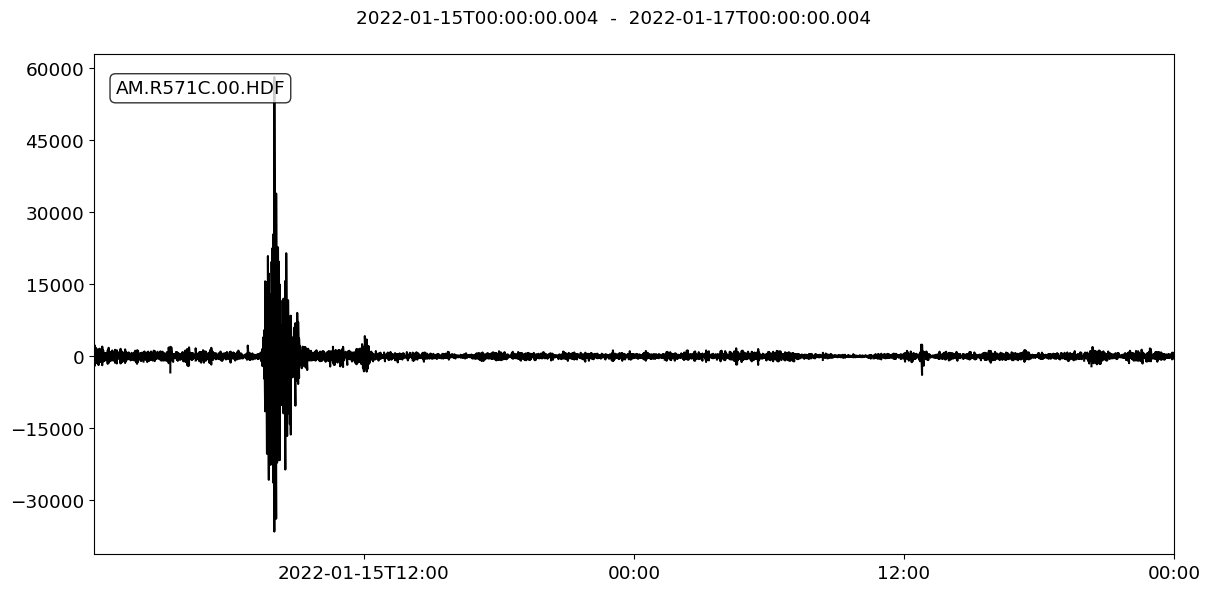

IndexError: list index out of range

In [120]:
if waveformcheckOPT:
    #_plot = st1.plot(size=(1000,450))
    if plotOPT:
        #st_tmp = st1.copy() + st2.copy()        
        #st_tmp = st1.copy() + st2.copy()+ st3.copy()        

        #st_tmp = st1.copy() 
        #st_tmp = st3.copy() 
        #st_tmp = st2.copy() 
        st_tmp = st7.copy() 

        plot_st = UTCDateTime("2022-01-16T00:10:50")  # 
        plot_et = UTCDateTime("2022-01-16T20:00:00")  #
        st_tmp.sort(keys=['channel'])   
        print(st_tmp)
        #_plot = st_tmp.copy().detrend("linear").plot(equal_scale=False, size=(1200,600))
        _plot = st_tmp.copy().detrend("linear").taper(0.001).filter("bandpass", 
                        freqmin=0.001, freqmax=0.01, zerophase=True).plot(equal_scale=False, size=(1200,600))
        _plot = st_tmp[1].copy().detrend("linear").taper(0.001).filter("bandpass", 
                        freqmin=0.001, freqmax=0.01, zerophase=True).plot(equal_scale=False, size=(1200,600), starttime=plot_st, endtime=plot_et)
        _plot = st_tmp[0].copy().detrend("linear").taper(0.001).filter("bandpass", 
                        freqmin=0.001, freqmax=0.01, zerophase=True).plot(equal_scale=False, size=(1200,600))

        #_plot = st_tmp.copy().detrend("linear").taper(0.001).filter("bandpass", freqmin=0.02, freqmax=0.05, zerophase=True).interpolate(sampling_rate=1.0).plot(equal_scale=False, size=(1200,600))
        #_plot = st_tmp.copy().detrend("linear").taper(0.001).filter("bandpass", freqmin=0.02, freqmax=0.05, zerophase=True).interpolate(sampling_rate=1.0).sort(keys=['channel']).plot(starttime=plot_st, endtime=plot_et, color='blue', equal_scale=False, size=(1200,600))
        #_plot = st_tmp.copy().detrend("linear").taper(0.001).sort(keys=['channel']).plot(starttime=plot_st, endtime=plot_et, 
        #                                                                                 color='blue', equal_scale=False, size=(1200,600))

        #_plot = st_tmp.copy().detrend("linear").sort(keys=['channel']).plot(starttime=plot_st, endtime=plot_et, color='blue', equal_scale=False, size=(1200,600))

      

In [45]:
st1[0].stats

               network: BK
               station: BKS
              location: 00
               channel: LHZ
             starttime: 2022-01-15T00:00:00.069538Z
               endtime: 2022-01-15T23:59:59.069538Z
         sampling_rate: 1.0
                 delta: 1.0
                  npts: 86400
                 calib: 1.0
_fdsnws_dataselect_url: http://service.ncedc.org/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 49, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 200704})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2022, 1, 16, 0, 0, 0, 69538)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2022, 1, 15, 0, 0, 0, 69538))']

In [46]:
evla = -20.5
evlo = -175.4

In [80]:
#def get_baz (st, inv, evla, evlo):
def get_baz (tr, inv, evla, evlo):

    #seedid=get_seedid(st[0])
    seedid=get_seedid(tr)

    sta_coord = get_sta_coord(seedid,inv,starttime)
    
    stla = sta_coord['latitude']
    stlo = sta_coord['longitude']
    class Obj: pass 
    tr.stats.coordinates = Obj()
    setattr(tr.stats.coordinates, "latitude", "longitude")

    tr.stats.coordinates.latitude = stla
    tr.stats.coordinates.longitude = stlo
    source_latitude = evla
    source_longitude = evlo
    
    station_latitude = stla
    station_longitude = stlo
    
    # theoretical backazimuth and distance
    baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

    #print('Epicentral distance [m]: ', baz[0])
    #print('Theoretical azimuth [deg]: ', baz[1])
    #print('Theoretical backazimuth [deg]: ', baz[2])
    
    return baz

In [81]:
for tr in st1:
    if tr.stats.station == "DRYC":
        st1.remove(tr)
for tr in st1:
    if tr.stats.station == "MOGU":
        st1.remove(tr)
for tr in st1:
    if tr.stats.station == "RVIT":
        st1.remove(tr)                

In [82]:
for tr in st1:
    print(tr)
    baz1 = get_baz(tr, inv1, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    tr.stats.distance = evdist_km*1000
    #print("# evdist_km = ",evdist_km)

BK.BKS.00.LHZ | 2022-01-15T00:00:00.069538Z - 2022-01-15T23:59:59.069538Z | 1.0 Hz, 86400 samples


In [99]:
for tr in st2:
    baz1 = get_baz(tr, inv2, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    tr.stats.distance = evdist_km*1000
    #print("# evdist_km = ",evdist_km)

In [98]:
for tr in st3:
    baz1 = get_baz(tr, inv3, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    tr.stats.distance = evdist_km*1000
    #tr.stats.channel = "LHZ"
    #tr.stats.location = "00"

    #print("# evdist_km = ",evdist_km)

In [85]:
for tr in st4:
    baz1 = get_baz(tr, inv4, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    tr.stats.distance = evdist_km*1000

In [86]:
for tr in st5:
    baz1 = get_baz(tr, inv5, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    tr.stats.distance = evdist_km*1000

In [112]:
for tr in st6:
    baz1 = get_baz(tr, inv6, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    tr.stats.distance = evdist_km*1000

In [125]:
for tr in st7:
    baz1 = get_baz(tr, inv7, evla, evlo)
    #print("# baz1[0] = ", baz1[0])
    evdist_km = baz1[0]/1000.0
    tr.stats.evdist_km = evdist_km
    tr.stats.distance = evdist_km*1000

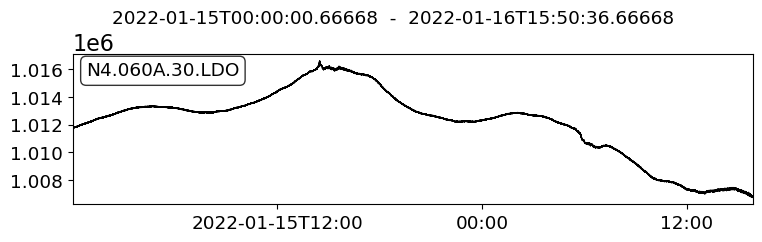

In [126]:
_plot = st6[0].plot()

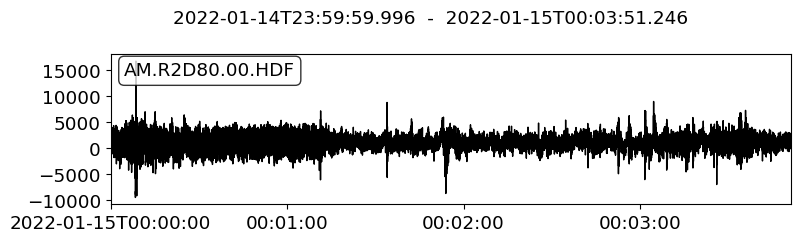

In [128]:
_plot = st7[0].plot()

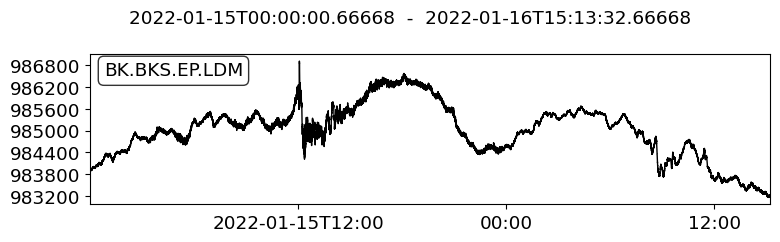

In [104]:
_plot = st2[0].plot()

In [ ]:
_plot = st1[0].plot()

In [ ]:
#_plot = st3.plot()

In [ ]:
tr=st1[0]
print(tr.stats)

In [ ]:
print(st2)

In [ ]:
tr=st2[0]
print(tr.stats)

In [ ]:
tr=st3[0]
print(tr.stats)

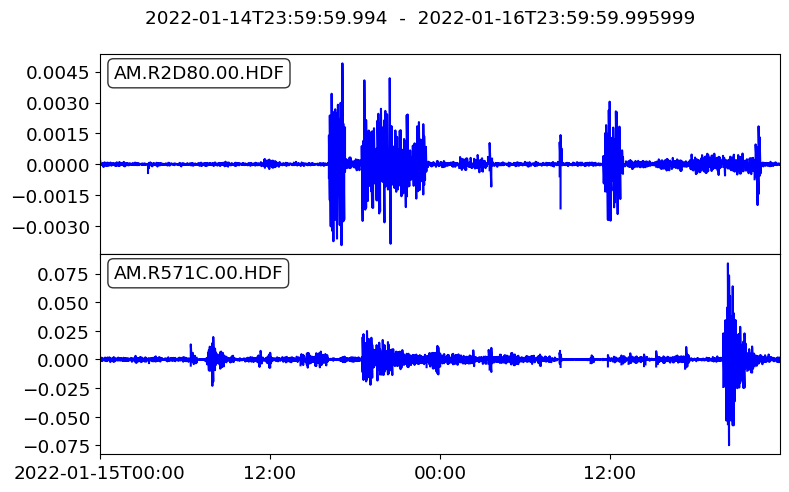

In [129]:
_plot = st7.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=0.001, freqmax=0.005, zerophase=True).plot(
                   color="blue", orientation="horizontal",linewidth=2.5, equal_scale=False, )

In [60]:
_plot = st6.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=0.001, freqmax=0.005, zerophase=True).plot(
                   color="blue", orientation="horizontal",linewidth=2.5, equal_scale=False, )

ValueError: Image size of 800x67000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 800x67000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x67000 with 268 Axes>

In [ ]:
_plot = st1.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=0.001, freqmax=0.01, zerophase=True).plot(
                   color="blue", orientation="horizontal",linewidth=2.5, equal_scale=False, )

In [ ]:
for tr in st1:
    if tr.stats.station == "YUBA" or tr.stats.station == "YBH" or tr.stats.station == "WINE" or \
    tr.stats.station == "AONC" or tr.stats.station == "BABI" or tr.stats.station == "BARR" or  \
    tr.stats.station == "BJES" or tr.stats.station == "BRIC" or tr.stats.station == "CVS" or  \
    tr.stats.station == "DMOR" or tr.stats.station == "DRDG" or tr.stats.station == "FARB" or  \
    tr.stats.station == "HATC" or tr.stats.station == "HAYF" or tr.stats.station == "JRSC" or  \
    tr.stats.station == "LCOW" or tr.stats.station == "MTOS" or tr.stats.station == "PETL" or   \
    tr.stats.station == "PKD" or tr.stats.station == "PORC" or tr.stats.station == "QRDG" or   \
    tr.stats.station == "SAO" or tr.stats.station == "TCHL" or tr.stats.station == "QRDG" or   \
    tr.stats.station == "WNEL" or tr.stats.station == "WENL" or tr.stats.station == "TOLH" or tr.stats.station == "THIS" :
        st1.remove(tr)


In [89]:
for tr in st3:
    if tr.stats.station == "TARA":
        st3.remove(tr)
        

In [102]:
for tr in st2:
    if tr.stats.station == "HOPS":
        st2.remove(tr)
        

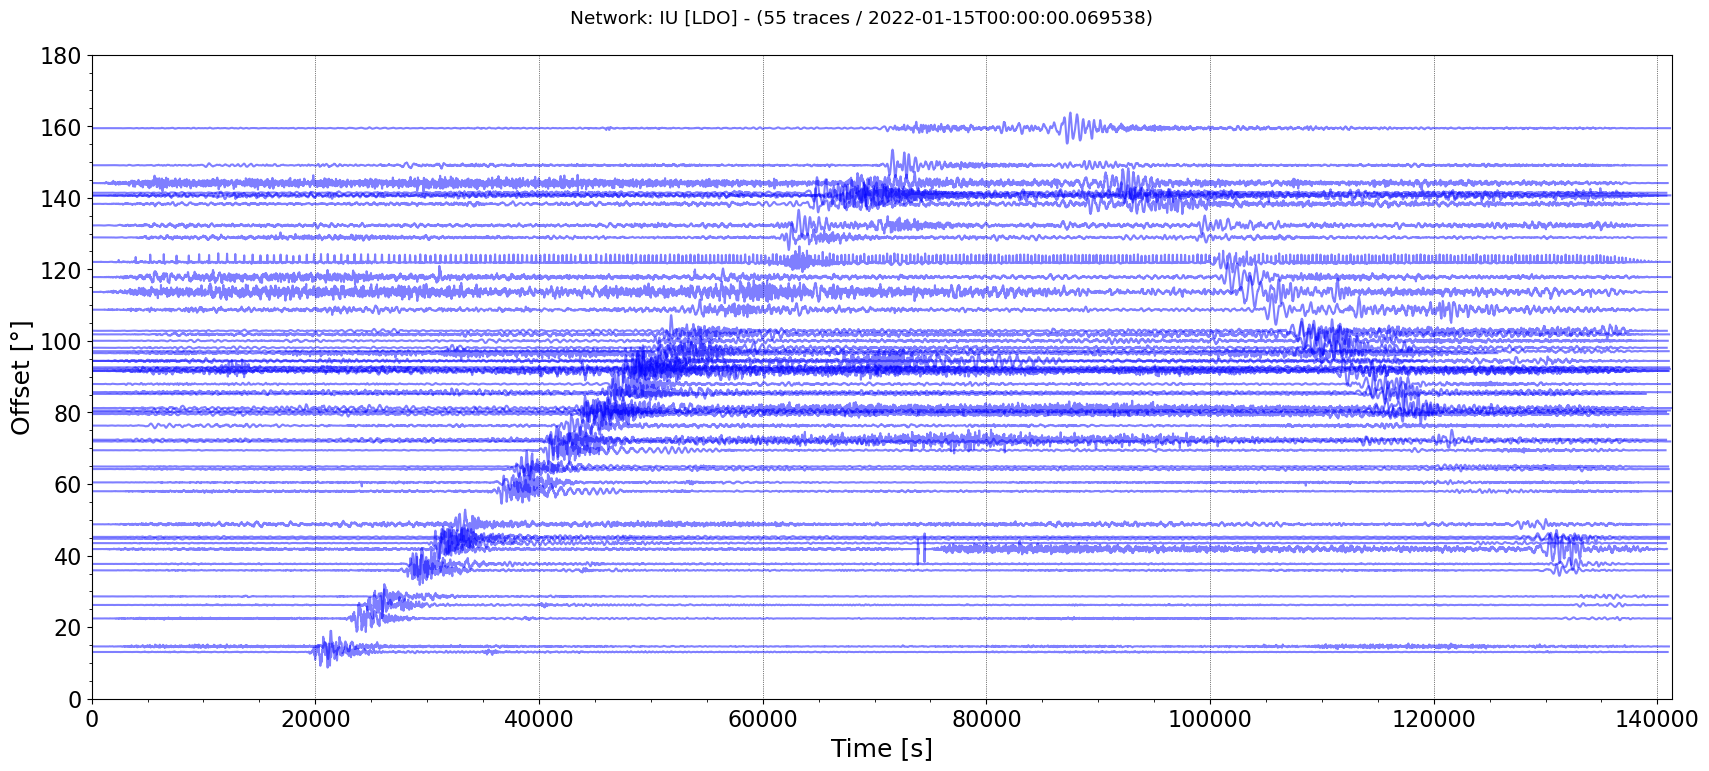

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [92]:
scale = 2
fl = 0.001
fh = 0.1
dmin = 0
dmax = 180
size=(1700,800)
_plot = st3.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size)

_plot = st3.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size, outfile="IU_LDO.eps")

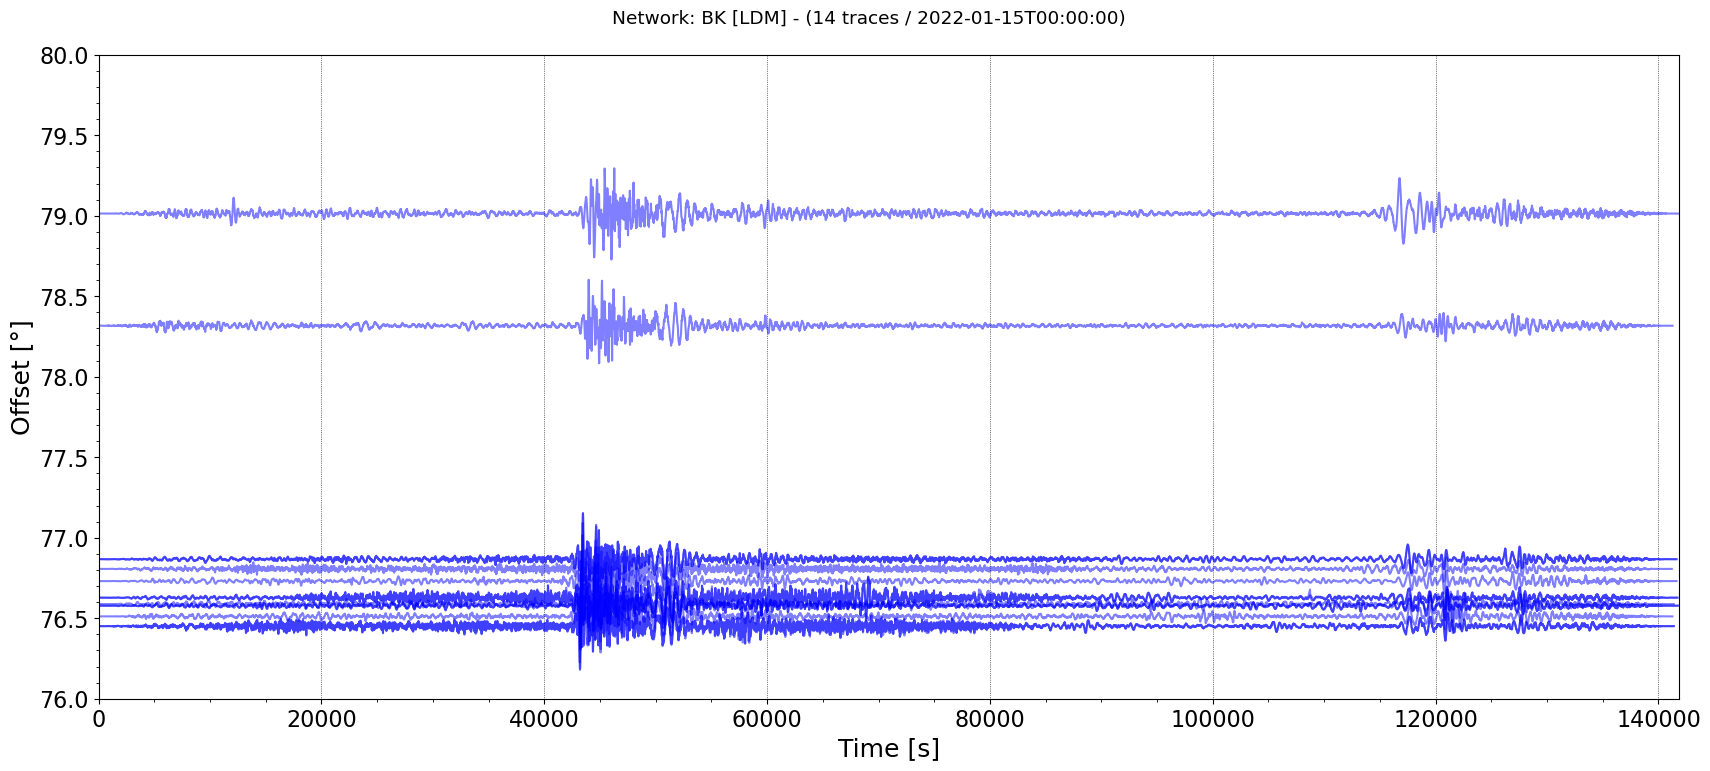

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [103]:
scale = 1.5
fl = 0.001
fh = 0.1
dmin = 76
dmax = 80
size=(1700,800)
_plot = st2.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size)

_plot = st2.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size, outfile="BK_LDM.eps", format="eps")

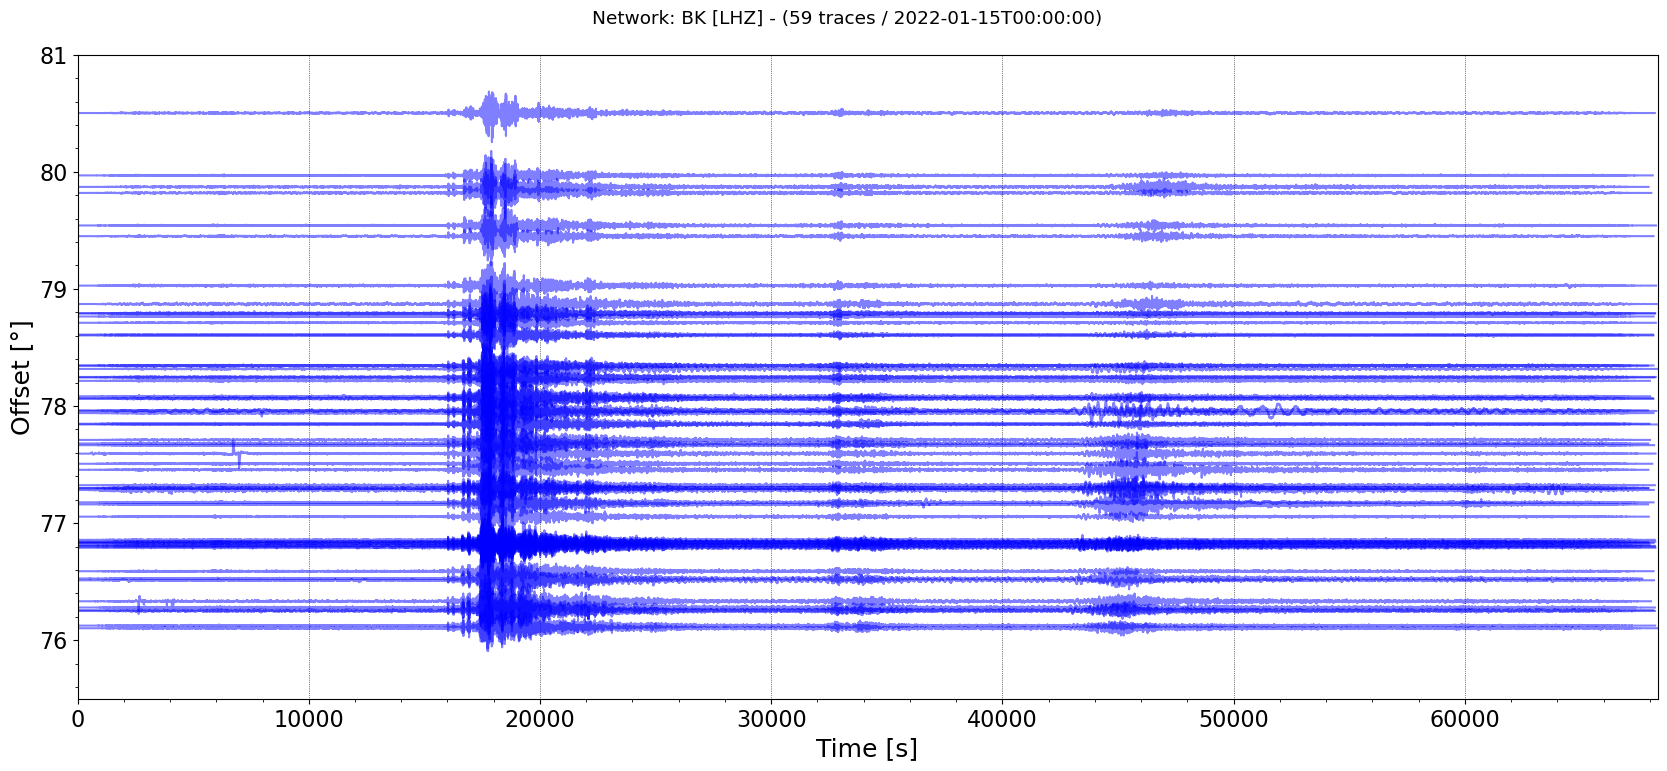

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [488]:
scale = 4.0
fl = 0.001
fh = 0.1
dmin = 75.5
dmax = 81
size=(1700,800)
tmin = 0
tmax = 63000
_plot = st1.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size)
_plot = st1.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size, outfile="BK_LHZ.eps", format="eps")
#recordstart=tmin, recordlength=tmax,

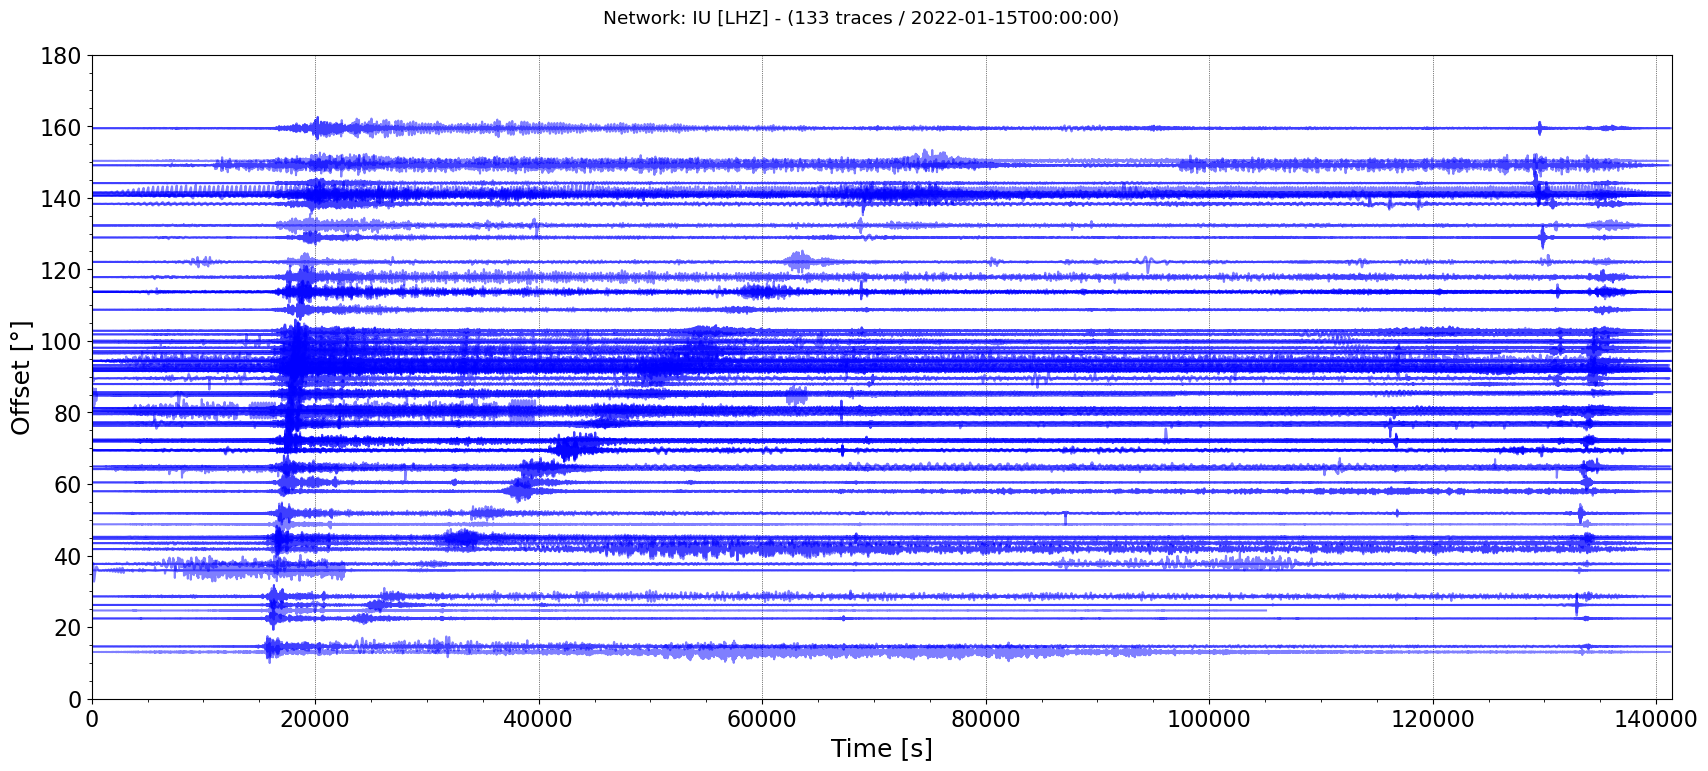

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [94]:
scale = 3.5
fl = 0.001
fh = 0.1
dmin = 0
dmax = 180
size=(1700,800)
_plot = st4.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size)

_plot = st4.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size, outfile="IU_LHZ.eps", format="eps")

/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_div

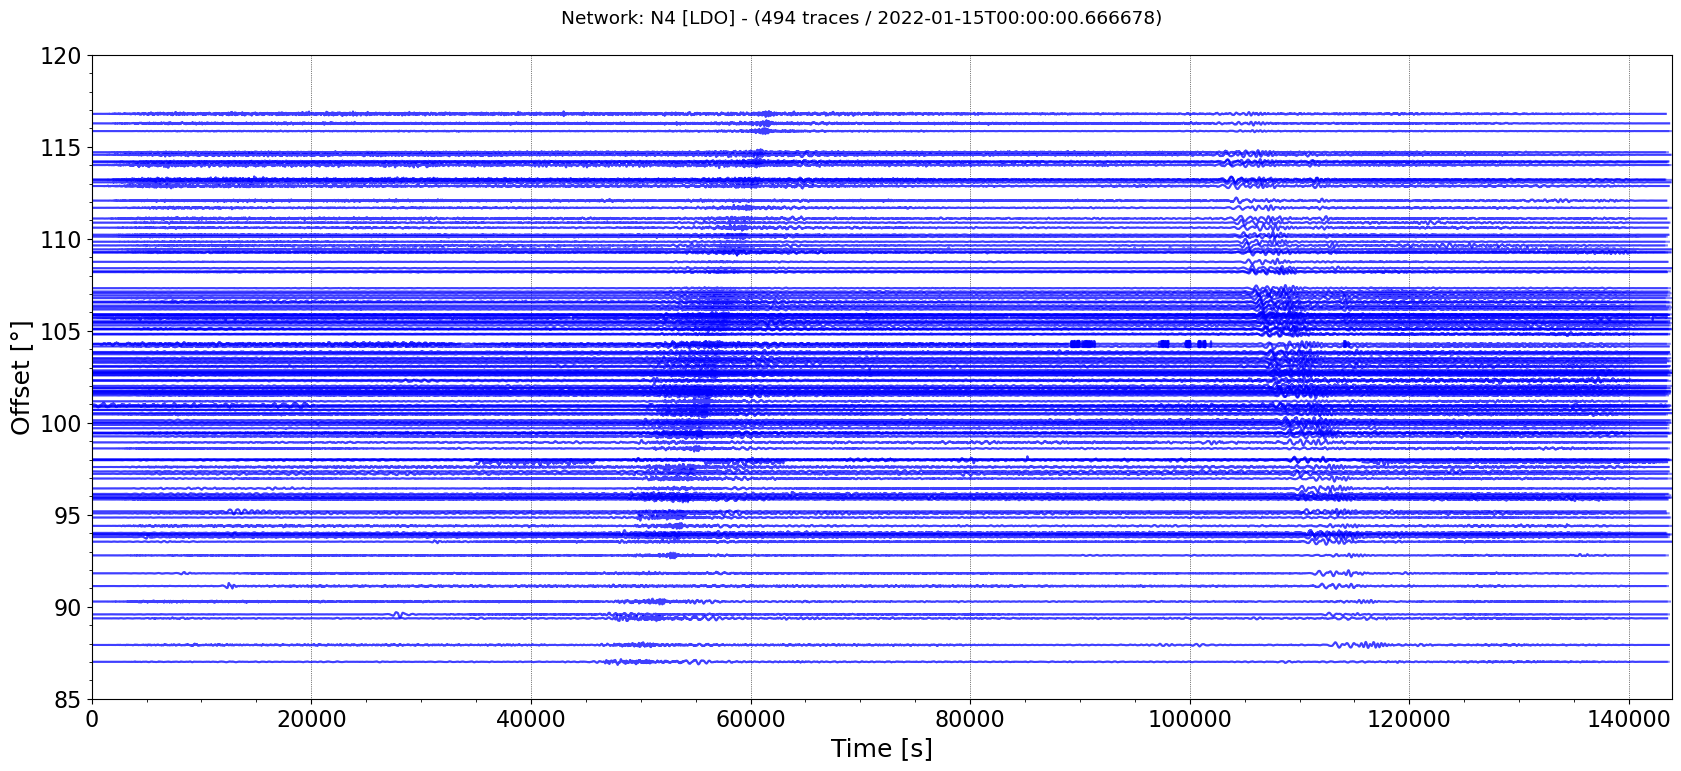

/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_divide
  data = ((self._tr_data[_tr] / self._tr_normfac[_tr] *
/Users/taira/opt/anaconda3/envs/netops/lib/python3.8/site-packages/obspy/imaging/waveform.py:1330: RuntimeWarning: invalid value encountered in true_div

In [115]:
scale = 3.5
fl = 0.001
fh = 0.1
#fl = 0.001
#fh = 0.05

dmin = 85
dmax = 120
size=(1700,800)
_plot = st6.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size)
_plot = st6.copy().normalize().detrend("linear").detrend("demean").taper(0.05).filter("bandpass", 
                        freqmin=fl, freqmax=fh, zerophase=True).plot(type='section', dist_degree=True,
                    ev_coord=(evla,evlo),scale=scale,
                    offset_min=dmin,
                   offset_max=dmax,
                   color="blue", orientation="horizontal",linewidth=1.5,size=size, outfile="N4_LDO.eps", format="eps")

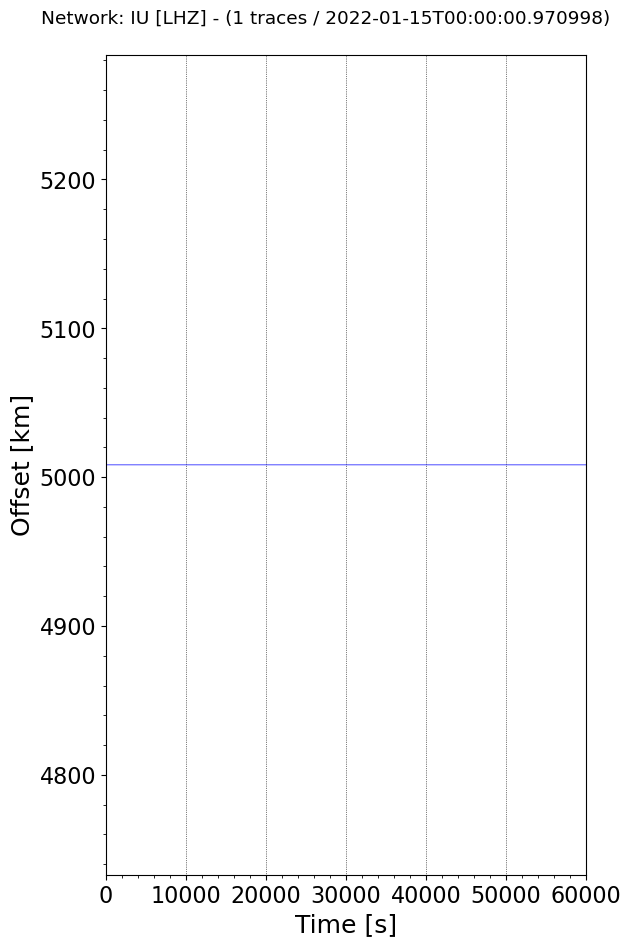

In [305]:
_plot = st3.plot(type='section', scale=0.0000001,
                   recordstart=0, recordlength=60000,
                   color="blue", size=(600,1000),orientation="horizontal",)

## Set time window for waveform similarity

In [83]:
#def
Rvel = 4.2 # surface wave velocity (km/s) 
# def
tw_pre_tw = -500 # sec before Rwave_arrival
# miyagi
#tw_pre_tw = -1000 # sec before Rwave_arrival
#def
tw_trim = 2000 # 2000-s window length
tw_trim = 2200 # 2000-s window length
#tw_trim = 2200 # 2000-s window length

tw_trim = 1700 # 2000-s window length



# deep EQ first P motion
#Rvel = 8.2 # surface wave velocity (km/s) 
#tw_pre_tw = -100 # sec before Rwave_arrival
#tw_trim = 1200 # 2000-s window length


# local
#tw_pre_tw = -60 # sec before Rwave_arrival
#tw_trim = 110 # 2000-s window length
#tw_trim = 60 # 2000-s window length

#
#tw_pre_tw = -15 # sec before p wave arrival
#tw_trim = 40 # 20-s window length
#
#tw_pre_tw = -15 # sec before p wave arrival
#tw_trim = 30 # 20-s window length

# Antelope Valley M6.0
#tw_pre_tw = -20 # sec before p wave arrival
#tw_trim =  120 # 20-s window length

#tw_pre_tw = -20 # sec before p wave arrival
#tw_trim =  300 # 20-s window length



## Set frequency range for waveform similarity
set the frequency range (fl and fh) for waveform similarity analysis. This example will use 0.02-0.10 Hz band. Also this will use for pre-filter when we correct the instrument response.

In [84]:
#fl2 < fl < fh < fh2

fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.10 #  Hz
fh2 = 0.20 # Hz

fl2 = 0.5 # Hz
fl = 1.0 # Hz 
fh = 5.0 #  Hz
fh2 = 6.0 # Hz

fl2 = 0.50 # Hz
fl = 0.75 # Hz 
fh = 2.0 #  Hz
fh2 = 2.5 # Hz

fl2 = 0.008 # Hz
fl = 0.01 # Hz 
fh = 0.1 #  Hz
fh2 = 0.4 # Hz

fl2 = 0.008 # Hz
fl = 0.01 # Hz 
fh = 30 #  Hz
fh2 = 40 # Hz

fl2 = 0.008 # Hz
fl = 0.01 # Hz 
fh = 10 #  Hz
fh2 = 16 # Hz


fl2 = 0.45 # Hz
fl = 0.5 # Hz 
fh = 2.0 #  Hz
fh2 = 3.0 # Hz

fl2 = 0.5 # Hz
fl = 1.0 # Hz 
fh = 5.0 #  Hz
fh2 = 6.0 # Hz

fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.10 #  Hz
fh2 = 0.20 # Hz

fl2 = 0.5 # Hz
fl = 1.0 # Hz 
fh = 5.0 #  Hz
fh2 = 6.0 # Hz




fl2 = 0.45 # Hz
fl = 0.5 # Hz 
fh = 2.0 #  Hz
fh2 = 3.0 # Hz



fl2 = 0.01 # Hz
fl = 0.035 # Hz 
fh = 0.060 #  Hz
fh2 = 0.07 # Hz

fl2 = 0.5 # Hz
fl = 1.0 # Hz 
fh = 5.0 #  Hz
fh2 = 6.0 # Hz



#fl2 = 0.004 # Hz
#fl = 0.005 # Hz 
#fh = 0.02 #  Hz
#fh2 = 0.03 # Hz






fl2 = 0.001 # Hz
fl =  0.005 # Hz 
fh =  0.020 #  Hz
fh2 = 0.05 # Hz

fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.10 #  Hz
fh2 = 0.20 # Hz

fl2 = 0.01 # Hz
fl = 0.05 # Hz 
fh = 0.20 #  Hz
fh2 = 0.30 # Hz




fl2 = 0.01 # Hz
fl = 0.05 # Hz 
fh = 0.20 #  Hz
fh2 = 0.30 # Hz



fl2 = 0.05 # Hz
fl = 0.10 # Hz 
fh = 2.00 #  Hz
fh2 = 3.00 # Hz



fl2 = 0.50 # Hz
fl = 1.0 # Hz 
fh = 4.0 #  Hz
fh2 = 5.0 # Hz


fl2 = 1 # Hz
fl = 2 # Hz 
fh = 2.2 #  Hz
fh2 = 2.4 # Hz


fl2 = 0.45 # Hz
fl = 0.5 # Hz 
fh = 2.0 #  Hz
fh2 = 3.0 # Hz



#fl2 < fl < fh < fh2


fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.05 #  Hz
fh2 = 0.08 # Hz

fl2 = 0.003 # Hz
fl = 0.005 # Hz 
fh = 0.02 #  Hz
fh2 = 0.03 # Hz
logOPT = 0

fl2 = 0.003 # Hz
fl = 0.005 # Hz 
fh = 1.0 #  Hz
fh2 = 2.0 # Hz
logOPT = 1

fl2 = 0.05 # Hz
fl = 0.1 # Hz 
fh = 5.0 #  Hz
fh2 = 6.0 # Hz
logOPT = 1
fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.05 #  Hz
fh2 = 0.08 # Hz
logOPT = 0





fl2 = 8.0 # Hz
fl = 10.0 # Hz 
fh = 20.0 #  Hz
fh2 = 22.0 # Hz
logOPT = 0

fl2 = 0.45 # Hz
fl = 0.5 # Hz 
fh = 2.0 #  Hz
fh2 = 3.0 # Hz
logOPT = 0


fl2 = 0.50 # Hz
fl = 1.0 # Hz 
fh = 4.0 #  Hz
fh2 = 5.0 # Hz
logOPT = 0

fl2 = 0.45 # Hz
fl = 0.5 # Hz 
fh = 1.5 #  Hz
fh2 = 2.0 # Hz
logOPT = 0




fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.10 #  Hz
fh2 = 0.20 # Hz
logOPT = 0









fl2 = 0.03 # Hz
fl = 0.04 # Hz 
fh = 0.06 #  Hz
fh2 = 0.08 # Hz
logOPT = 0




fl2 = 4.0 # Hz
fl = 5.0 # Hz 
fh = 10.0 #  Hz
fh2 = 11.0 # Hz
logOPT = 0


fl2 = 2.00 # Hz
fl = 2.5 # Hz 
fh = 6.0 #  Hz
fh2 = 7.0 # Hz
logOPT = 0





fl2 = 1/500 # Hz
fl = 1/400 # Hz 
fh = 1/20 #  Hz
fh2 = 1/10 # Hz
logOPT = 1


fl2 = 1/1100 # Hz
fl = 1/1000 # Hz 
fh = 1/10 #  Hz
fh2 = 1/8 # Hz
logOPT = 1


fl2 = 0.03 # Hz
fl = 0.04 # Hz 
fh = 0.07 #  Hz
fh2 = 0.08 # Hz
logOPT = 0



fl = 0.5 # Hz 
fh = 10.0 #  Hz
fh2 = 11.0 # Hz
logOPT = 0



fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.05 #  Hz
fh2 = 0.08 # Hz
logOPT = 0





fl2 = 0.08 # Hz
fl = 0.10 # Hz 
fh = 0.50 #  Hz
fh2 = 1.1 # Hz
logOPT = 0





fl2 = 0.9 # Hz
fl = 1.0 # Hz 
fh = 10.0 #  Hz
fh2 = 11.0 # Hz
logOPT = 0

fl2 = 0.08 # Hz
fl = 0.10 # Hz 
fh = 0.4 #  Hz
fh2 = 0.45 # Hz
logOPT = 0



fl2 = 0.04 # Hz
fl = 0.05 # Hz 
fh = 0.06 #  Hz
fh2 = 0.07 # Hz
logOPT = 0

fl2 = 0.03 # Hz
fl = 0.04 # Hz 
fh = 0.25 #  Hz
fh2 = 0.3# Hz
logOPT = 0


fl2 = 0.1 # Hz
fl = 0.2 # Hz 
fh = 0.5 #  Hz
fh2 = 0.6# Hz
logOPT = 0


fl2 = 0.03 # Hz
fl = 0.04 # Hz 
fh = 0.07 #  Hz
fh2 = 0.08 # Hz
logOPT = 0



fl2 = 0.50 # Hz
fl = 1.0 # Hz 
fh = 4.0 #  Hz
fh2 = 5.0 # Hz
logOPT = 0

fl2 = 0.5 # Hz
fl = 1.0 # Hz 
fh = 10.0 #  Hz
fh2 = 11.0 # Hz
logOPT = 0



fl2 = 1/60 # Hz
fl = 1/50 # Hz 
fh = 1/20 #  Hz
fh2 = 1/10 # Hz
logOPT = 1


fl2 = 1/60 # Hz
fl = 1/50 # Hz 
fh = 1/2 #  Hz
fh2 = 1/1 # Hz
logOPT = 0

fl2 = 0.03 # Hz
fl = 0.04 # Hz 
fh = 0.07 #  Hz
fh2 = 0.08 # Hz
logOPT = 0


fl2 = 0.45 # Hz
fl = 0.5 # Hz 
fh = 2.0 #  Hz
fh2 = 3.0 # Hz
logOPT = 0


fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.10 #  Hz
fh2 = 0.20 # Hz
logOPT = 0


#pre_filt = [0.015, 0.02, 45, 50]


pre_filt = [fl2, fl, fh, fh2]

## Downloading seismic data
use get_waveforms to download data and do st.plot() for plotting. Also use get_stsations to obtation station inventory file. 

# starttime =  2022-01-15T00:00:00.000000Z
# endtime =  2022-01-15T20:00:00.000000Z
# sta1 =  BKS
# net1 =  BK
# com1 =  LH?
# loc1 =  00


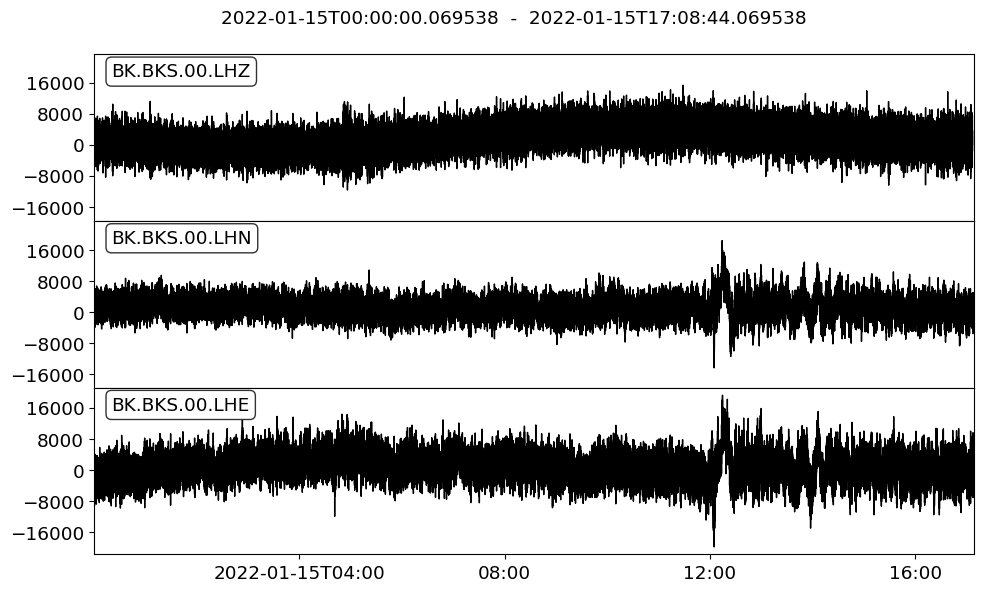

In [85]:
if sta1 == "AASX":
    mseedid = "2021.222.212100"
    st1 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK.HHE.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK.HHN.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK.HHZ.00.D."+mseedid)
    st1.trim(starttime, endtime)  

    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "PABC":
    mseedid = "2021.225.054555"
    st1 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK.HHE.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK.HHN.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK.HHZ.00.D."+mseedid)
    st1.trim(starttime, endtime)  

    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "MERX":
    st1 = read("http://ncedc.org/ftp/outgoing/taira/MERC.BK.HHE.00.D.2020.275.003127")
    st1 += read("http://ncedc.org/ftp/outgoing/taira/MERC.BK.HHN.00.D.2020.275.003127")
    st1 += read("http://ncedc.org/ftp/outgoing/taira/MERC.BK.HHZ.00.D.2020.275.003127")

    st1.trim(starttime, endtime)  

    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "BK50" or sta1 == "BK51" or sta1 == "BK52" or sta1 == "BK53" or sta1 == "BK54" or \
    sta1 == "BK60"  or sta1 == "BK61" or sta1 == "BK62" or sta1 == "BK63" or sta1 == "BK64" or sta1 == "BK65" or \
    sta1 == "BK70" or sta1 == "BK71" or sta1 == "BK72" or sta1 == "BK73" or sta1 == "BK74":
    #sta1 == "BK80" or sta1 == "BK81" or sta1 == "BK82" or sta1 == "BK83" or sta1 == "BK84":
    #mseedid = "2021.337.044004"
    #mseedid = "2021.226.122908"
    #mseedid = "2021.234.213320"
    #mseedid = "2021.239.044744"
    #mseedid = "2021.275.062918"
    #mseedid = "2021.339.020828"
    #mseedid = "2021.347.214815"
    #mseedid = "2021.348.032024"
    #mseedid = "2021.352.000014"
    mseedid = "2021.354.201019"

    chname = "LH"
    chname = "HH"

    st1 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"E.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"N.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"Z.00.D."+mseedid)
    st1.trim(starttime, endtime)  

    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "BK83":
    #mseedid = "2021.226.122908"
    #mseedid = "2021.234.213320"
    #mseedid = "2021.239.044744"
    mseedid = "2021.275.062918"
    chname = "LH"
    chname = "HH"

    st1 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"E.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"N.00.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"Z.00.D."+mseedid)
    st1.trim(starttime, endtime)  

    inv1 = read_inventory("BK.BK83.xml")
           
elif sta1 == "BK81":
    #mseedid = "2021.226.122908"
    #mseedid = "2021.234.213320"
    #mseedid = "2021.239.044744"
    mseedid = "2021.275.062918"
    chname = "LH"
    chname = "HH"

    #st1 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"E.00.D."+mseedid)
    #st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"N.00.D."+mseedid)
    #st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"Z.00.D."+mseedid)

    st1 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"E.01.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"N.01.D."+mseedid)
    st1 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta1+".BK."+chname+"Z.01.D."+mseedid)    
    st1.trim(starttime, endtime)  

    inv1 = read_inventory("BK.BK81.xml")
                   
elif sta1 == "TOLX":
    st1 = read("http://ncedc.org/ftp/outgoing/taira/TOLH.BK.HHE.00.D.2020.276.123247")
    st1 += read("http://ncedc.org/ftp/outgoing/taira/TOLH.BK.HHN.00.D.2020.276.123247")
    st1 += read("http://ncedc.org/ftp/outgoing/taira/TOLH.BK.HHZ.00.D.2020.276.123247")   
    st1.trim(starttime, endtime)  
    inv1 = read_inventory("station_BVtest.xml")

    
    
#elif sta1 == "BCCR":
elif sta1 == "BCCX":

    st1 = read("http://ncedc.org/ftp/outgoing/taira/BCCR.BK.HHE.00.D.2020.284.012411")
    st1 += read("http://ncedc.org/ftp/outgoing/taira/BCCR.BK.HHN.00.D.2020.284.012411")
    st1 += read("http://ncedc.org/ftp/outgoing/taira/BCCR.BK.HHZ.00.D.2020.284.012411")   
    #st1.trim(starttime, endtime)  
    inv1 = read_inventory("station_BVtest.xml")

    
    
elif sta1 == "MZTA":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "PORC":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")    
    
elif sta1 == "CLRV":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")    
    
    
elif sta1 == "WROX":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "GRPK":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")
elif sta1 == "DRDG":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "SANX":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "GUMB":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")
    
elif sta1 == "MILX":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")    
elif sta1 == "YBHX" and loc1 == "50":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    #inv1_dataless = read_inventory("http://ncedc.org/ftp/outgoing/taira/YBH.dataless", format="SEED")
    #inv1_dataless.write("inv1.xml", format="STATIONXML")
    #inv1_resp =  read_inventory("http://ncedc.org/ftp/outgoing/taira/RESP.BK.YBH.50.HHZ", format="RESP")
    #inv1_resp += read_inventory("http://ncedc.org/ftp/outgoing/taira/RESP.BK.YBH.50.HHN", format="RESP")
    #inv1_resp += read_inventory("http://ncedc.org/ftp/outgoing/taira/RESP.BK.YBH.50.HHE", format="RESP")
    #inv1_resp.write("inv1.xml", format="STATIONXML")
    #inv1 = read_inventory("inv1.xml")
    inv1 = read_inventory("http://ncedc.org/ftp/outgoing/taira/BK.YBH.xml")

elif sta1 == "DCMP":
    print("# read")
    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = read_inventory("station_BVtest.xml")

elif sta1 == "TBRD":
    print("# starttime = ", starttime)
    print("# endtime = ", endtime)
    print("# sta1 = ", sta1)
    print("# net1 = ", net1)


    st1 = client_iris.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = client1.get_stations(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     level="response")
else:
    print("# starttime = ", starttime)
    print("# endtime = ", endtime)
    print("# sta1 = ", sta1)
    print("# net1 = ", net1)
    print("# com1 = ", com1)
    print("# loc1 = ", loc1)


    st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv1 = client1.get_stations(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     level="response")

if plotOPT:
    _plot = st1.plot(size=(1000,600))
    #_plot = st1.plot()



In [86]:
print(st1)
#pint(inv1)

3 Trace(s) in Stream:
BK.BKS.00.LHE | 2022-01-15T00:00:00.069538Z - 2022-01-15T17:08:03.069538Z | 1.0 Hz, 61684 samples
BK.BKS.00.LHN | 2022-01-15T00:00:00.069538Z - 2022-01-15T17:08:44.069538Z | 1.0 Hz, 61725 samples
BK.BKS.00.LHZ | 2022-01-15T00:00:00.069538Z - 2022-01-15T17:07:01.069538Z | 1.0 Hz, 61622 samples


In [87]:
print(inv1)

Inventory created at 2022-01-15T09:10:47.000000Z
	Created by: NCEDC WEB SERVICE: fdsnws-station | version: 1.1
		    http://service.ncedc.org/fdsnws/station/1/query?net=BK&sta=BKS&cha=...
	Sending institution: NCEDC (NCEDC)
	Contains:
		Networks (1):
			BK
		Stations (1):
			BK.BKS (Byerly Seismographic Vault, Berkeley, CA, USA)
		Channels (3):
			BK.BKS.00.LHZ, BK.BKS.00.LHN, BK.BKS.00.LHE


In [88]:
#inv1.write(plot_dir+"/inv1.sacpz", format='SACPZ')

In [89]:
#vars(inv1[0][0][0])

In [181]:
#_plot = inv1.plot_response(min_freq=0.01)

In [182]:
print(st1)

3 Trace(s) in Stream:
BK.BKS.00.HHE | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHN | 2021-12-20T20:10:19.108391Z - 2021-12-20T20:25:19.098391Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples


# sta2 =  BKS
# net2 =  BK
# com2 =  HN?
# loc2 =  00


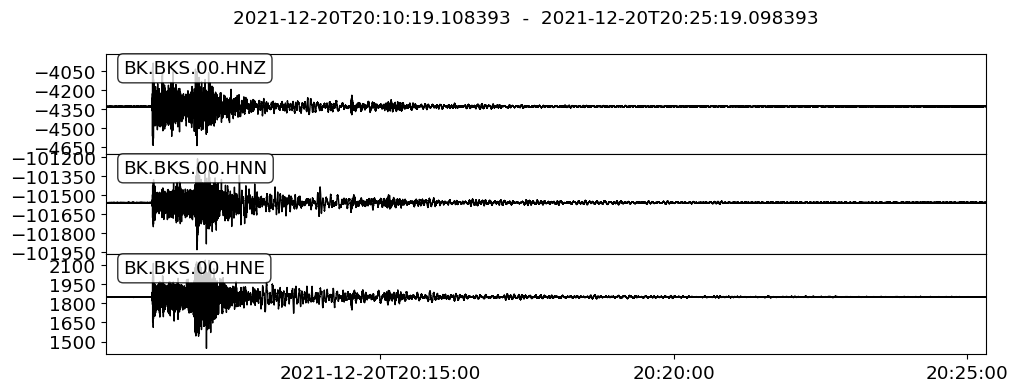

In [183]:
if sta2 == "BK50" or sta2 == "BK51" or sta2 == "BK52" or sta2 == "BK53" or sta2 == "BK54" or \
    sta2 == "BK60"  or sta2 == "BK61" or sta2 == "BK62" or sta2 == "BK63" or sta2 == "BK64" or sta2 == "BK65" or \
    sta2 == "BK70" or sta2 == "BK71" or sta2 == "BK72" or sta2 == "BK73" or sta2 == "BK74":
    mseedid = "2021.226.122908"
    mseedid = "2021.234.213320"
    mseedid = "2021.239.044744"
    mseedid = "2021.339.020828"
    mseedid = "2021.347.214815"
    mseedid = "2021.348.032024"
    mseedid = "2021.352.000014"

    chname = "LN"
    chname = "HN"

    st2 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta2+".BK."+chname+"E.00.D."+mseedid)
    st2 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta2+".BK."+chname+"N.00.D."+mseedid)
    st2 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta2+".BK."+chname+"Z.00.D."+mseedid)
    st2.trim(starttime, endtime)  

    inv2 = read_inventory("station_BVtest.xml")
    
elif sta2 == "PABC":
    mseedid = "2021.225.054555"
    st2 = read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta2+".BK.HNE.00.D."+mseedid)
    st2 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta2+".BK.HNN.00.D."+mseedid)
    st2 += read("http://ncedc.org/ftp/outgoing/taira/WQC/bktest_data/"+sta2+".BK.HNZ.00.D."+mseedid)
    st2.trim(starttime, endtime)  

    inv2 = read_inventory("station_BVtest.xml")
    
elif sta2 == "MERX":
    st2 = read("http://ncedc.org/ftp/outgoing/taira/MERC.BK.HNE.00.D.2020.275.003127")
    st2 += read("http://ncedc.org/ftp/outgoing/taira/MERC.BK.HNN.00.D.2020.275.003127")
    st2 += read("http://ncedc.org/ftp/outgoing/taira/MERC.BK.HNZ.00.D.2020.275.003127")
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "TOLX":
    st2 = read("http://ncedc.org/ftp/outgoing/taira/TOLH.BK.HNE.00.D.2020.276.123247")
    st2 += read("http://ncedc.org/ftp/outgoing/taira/TOLH.BK.HNN.00.D.2020.276.123247")
    st2 += read("http://ncedc.org/ftp/outgoing/taira/TOLH.BK.HNZ.00.D.2020.276.123247")
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "BCCX":
    st2 = read("http://ncedc.org/ftp/outgoing/taira/BCCR.BK.HNE.00.D.2020.284.012411")
    st2 += read("http://ncedc.org/ftp/outgoing/taira/BCCR.BK.HNN.00.D.2020.284.012411")
    st2 += read("http://ncedc.org/ftp/outgoing/taira/BCCR.BK.HNZ.00.D.2020.284.012411")   
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "SANX":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")
    
elif sta2 == "MILX":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "MZTA":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "PORC":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "CLRV":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "GUMB":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")
    
elif sta2 == "MNRC" and com2 == "HN?":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "WROX":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "GRPK":
    print("# read")
    st2 = client1.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                    starttime=starttime, endtime=endtime, 
                     attach_response=True)
    inv2 = read_inventory("station_BVtest.xml")

elif sta2 == "TBRD":
    print("# sta2 = ", sta2)
    print("# net2 = ", net2)
    print("# com2 = ", com2)
    print("# loc2 = ", loc2)

    st2 = client_iris.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)


    # for station locations
    inv2 = client2.get_stations(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     level="response")
    
else:
    print("# sta2 = ", sta2)
    print("# net2 = ", net2)
    print("# com2 = ", com2)
    print("# loc2 = ", loc2)

    st2 = client2.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)


    # for station locations
    inv2 = client2.get_stations(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     level="response")


if plotOPT:
    _plot = st2.plot(size=(1000,400))

In [184]:


#_plot = st2.plot(size=(1000,450))

In [185]:
print(st2)

3 Trace(s) in Stream:
BK.BKS.00.HNE | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNN | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples


In [186]:
st1_merge = st1.copy().merge()
print(st1_merge)
st1 = st1_merge.copy()



st2_merge = st2.copy().merge()
print(st2_merge)
st2 = st2_merge.copy()

3 Trace(s) in Stream:
BK.BKS.00.HHE | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHN | 2021-12-20T20:10:19.108391Z - 2021-12-20T20:25:19.098391Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
3 Trace(s) in Stream:
BK.BKS.00.HNE | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNN | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples


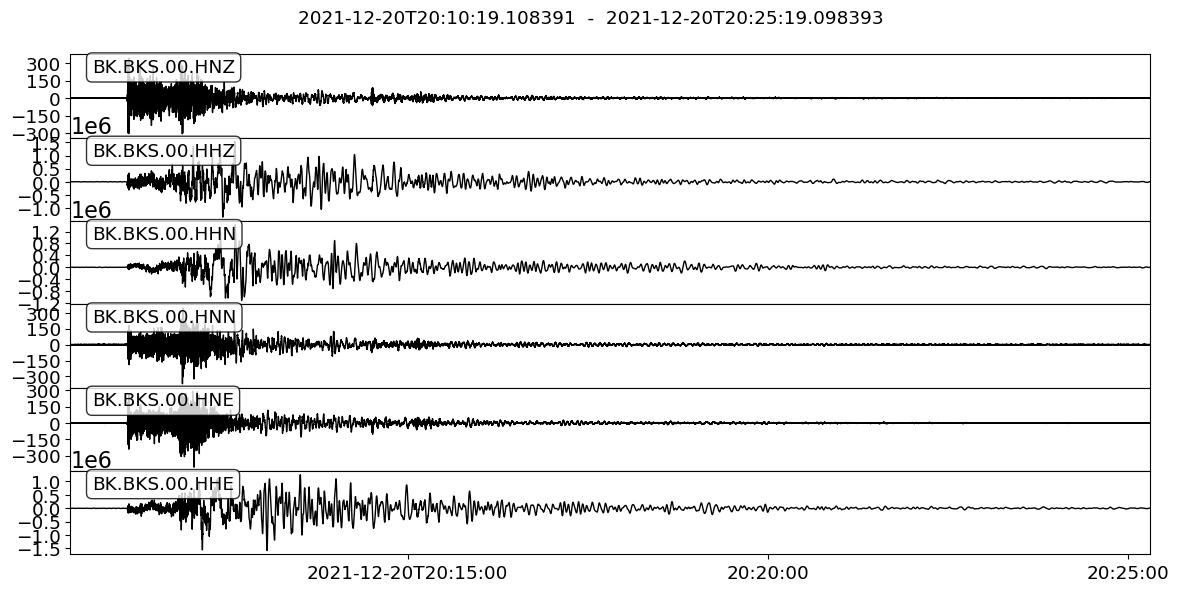

In [187]:
if plotOPT:
    st_tmp = st1.copy() + st2.copy()
    #st_tmp = st1.copy() 
    _plot = st_tmp.copy().detrend("linear").taper(0.001).plot(equal_scale=False, 
                                                              size=(1200,600))
    #_plot = st_tmp.copy().detrend("linear").taper(0.001).filter("bandpass", freqmin=0.04, freqmax=0.1, zerophase=True).interpolate(sampling_rate=1.0).plot(equal_scale=False, size=(1200,600))

In [188]:
#inv2.write(plot_dir+"/inv2.sacpz", format='SACPZ')

In [189]:
#_plot = inv2.plot_response(min_freq=0.01)

## Removing instrument response 
use st_remove_resp function uses obspy remove_response to remove instrument response. Example will provide ground velocity data (m/s)

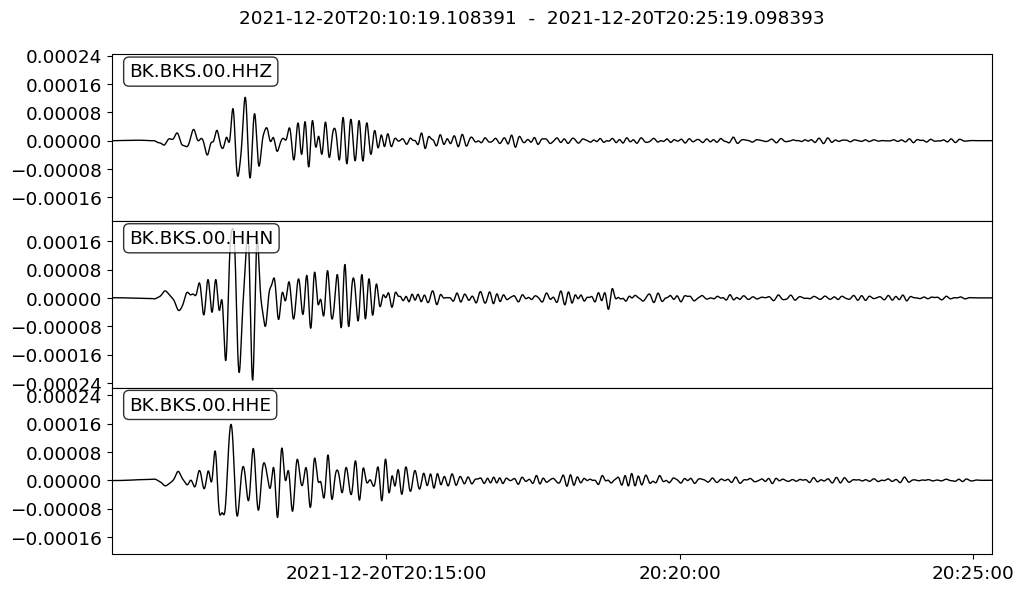

In [190]:
if sta1 == "BK60"  or sta1 == "BK61" or sta1 == "BK62" or sta1 == "BK63" or sta1 == "BK64" or sta1 == "BK65" or \
    sta1 == "DCMP" or sta1 == "MZTA" or sta1 == "PORC" or sta1 == "CLRV" or sta1 == "GRPK" or sta1 == "GUMB" or \
    sta1 == "BK50" or sta1 == "BK51" or sta1 == "BK52" or sta1 == "BK53" or sta1 == "BK54" or sta1 == "BK57" or \
    sta1 == "BK70" or sta1 == "BK71" or sta1 == "BK72" or sta1 == "BK73" or sta1 == "BK74" or \
    sta1 == "BK80" or sta1 == "BK81" or sta1 == "BK82" or sta1 == "BK83" or sta1 == "BK84" or \
    sta1 == "PABC" or sta1 == "SANX" or sta1 == "MILX":
    print("# use inv1")
    st1 = st_remove_resp_inv(st1, deciopt_1, decifactor_1, pre_filt, "VEL", inv1)

else:
    st1 = st_remove_resp(st1, deciopt_1, decifactor_1, pre_filt, "VEL")
    #st1 = st_remove_resp(st1, deciopt_1, decifactor_1, pre_filt_tremor, "VEL")

if plotOPT:
    _plot = st1.plot(size=(1000,600))


In [191]:
#    _plot = st1.plot(size=(1200,400))


In [192]:
print(st1)

3 Trace(s) in Stream:
BK.BKS.00.HHE | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHN | 2021-12-20T20:10:19.108391Z - 2021-12-20T20:25:19.098391Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples


In [193]:
#print(inv2)

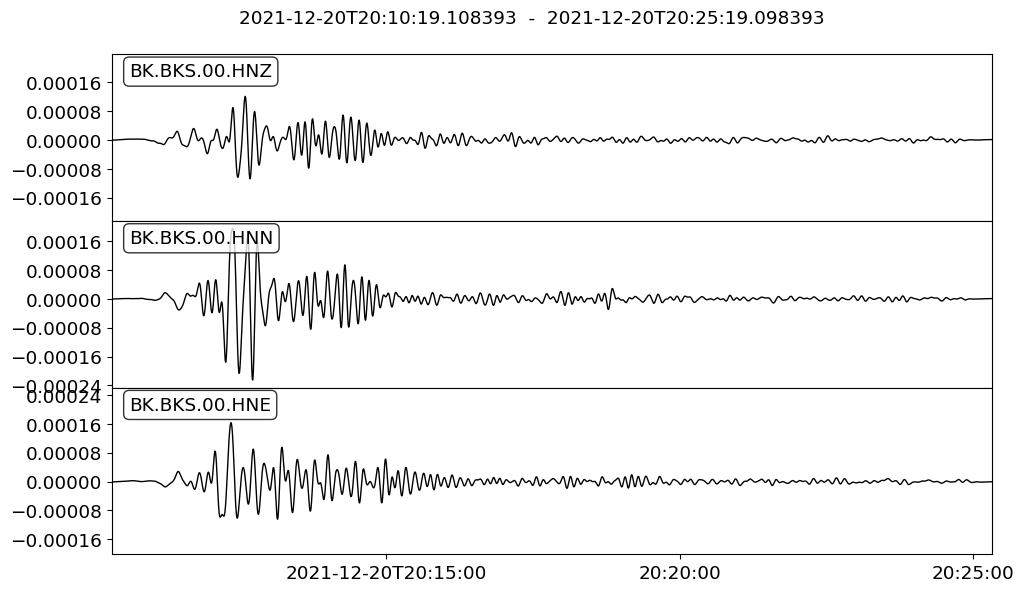

In [194]:
#print(st2)
if  sta2 == "BK60" or sta2 == "BK61" or sta2 == "BK62" or sta2 == "BK63" or sta2 == "BK64" or sta2 == "BK65" or \
    sta2 == "BCCX" or sta2 == "MZTA" or sta2 == "PORC" or sta2 == "CLRV" or\
    sta2 == "BK50" or sta2 == "BK51" or sta2 == "BK52" or sta2 == "BK53" or sta2 == "BK54" or \
    sta2 == "BK70" or sta2 == "BK71" or sta2 == "BK72" or sta2 == "BK73" or sta2 == "BK74" or \
    sta2 == "BK80" or sta2 == "BK81" or sta2 == "BK82" or sta2 == "BK83" or sta2 == "BK84" or \
    (sta2 == "MNRC" and com2 =="HN?") or \
    sta2 == "PABC" or sta2 == "SANX" or sta2 == "MILX" :
    
    print("# use inv2")
    st2 = st_remove_resp_inv(st2, deciopt_2, decifactor_2, pre_filt, "VEL", inv2)

else:
    st2 = st_remove_resp(st2, deciopt_2, decifactor_2, pre_filt, "VEL")


if plotOPT:
    _plot = st2.plot(size=(1000,600))

In [195]:
#st1 = st1.trim(starttime+(60*20), endtime-10)  
#st1_zne = st1_zne.trim(starttime+(60*20), endtime-10)  
#print(st1)
#st2 = st2.trim(starttime+(60*20), endtime-10)  
#st2_zne = st2_zne.trim(starttime+(60*20), endtime-10)  
#print(st2)


## Rotating seismic data into ZNE coordinate
use get_zne_data. This will provide ZNE coordinate data. 

# seedid =  BK.BKS.00.HHE [{'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}]
# seedid =  BK.BKS.00.HHE [{'azimuth': 90.0, 'dip': 0.0}]
# seedid =  BK.BKS.00.HHN [{'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}, {'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}]
# seedid =  BK.BKS.00.HHN [{'azimuth': 90.0, 'dip': 0.0}, {'azimuth': 0.0, 'dip': 0.0}]
# seedid =  BK.BKS.00.HHZ [{'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}, {'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}, {'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}]
# seedid =  BK.BKS.00.HHZ [{'azimuth': 90.0, 'dip': 0.0}, {'azimuth': 0.0, 'dip': 0.0}, {'azimuth': 0.0, 'dip': -90.0}]
# st2 =  BK.BKS.00.HHZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
# st

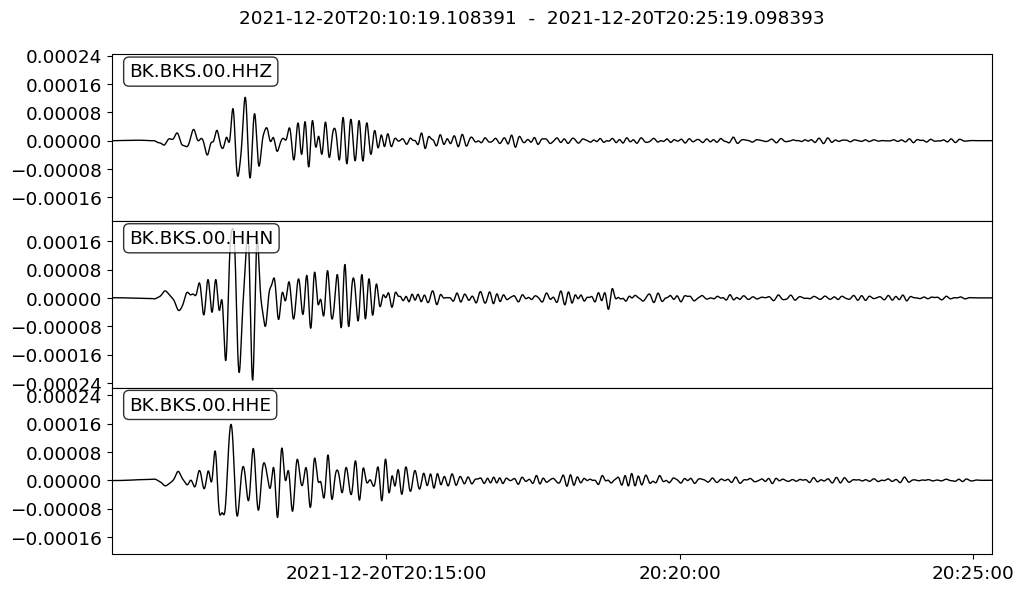

In [196]:
st1_zne = st1.copy()

try:
    st1_zne = get_zne_data (st1_zne, inv1, starttime)
except:
    print("error! st1 zne")
    st1_zne = st1.copy()

if plotOPT:
    _plot = st1_zne.plot(size=(1000,600))

In [197]:
#_plot = st1_zne.plot(size=(1000,600), equal_scale=False)

# seedid =  BK.BKS.00.HNE [{'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}]
# seedid =  BK.BKS.00.HNE [{'azimuth': 90.0, 'dip': 0.0}]
# seedid =  BK.BKS.00.HNN [{'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}, {'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}]
# seedid =  BK.BKS.00.HNN [{'azimuth': 90.0, 'dip': 0.0}, {'azimuth': 0.0, 'dip': 0.0}]
# seedid =  BK.BKS.00.HNZ [{'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}, {'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}, {'latitude': 37.87622, 'longitude': -122.23558, 'elevation': 243.9, 'local_depth': 25.6}]
# seedid =  BK.BKS.00.HNZ [{'azimuth': 90.0, 'dip': 0.0}, {'azimuth': 0.0, 'dip': 0.0}, {'azimuth': 0.0, 'dip': -90.0}]
# st2 =  BK.BKS.00.HNZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
# st

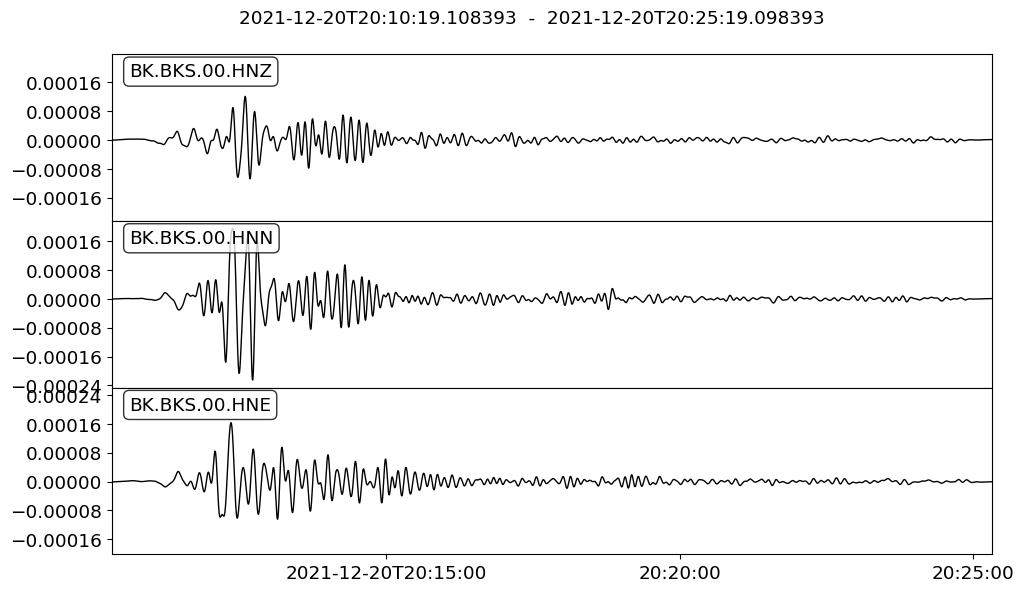

In [198]:
st2_zne = st2.copy()

try:
    st2_zne = get_zne_data (st2_zne, inv2, starttime)
except:
    print("error! st2 zne")
    st2_zne = st2.copy()

if plotOPT:   
    _plot = st2_zne.plot(size=(1000,600))

In [199]:
#print(starttime)
#print(endtime)

## Rotating seismic data into ZRT coordinate 
get_baz to esimate the back azimuth and then use obspy rotate to covert ZNE data into ZRT data

Epicentral distance [m]:  345940.20040773024
Epicentral distance [km]:  345.94020040773023
Theoretical azimuth [deg]:  140.6740274863965
Theoretical backazimuth [deg]:  322.24564704631103


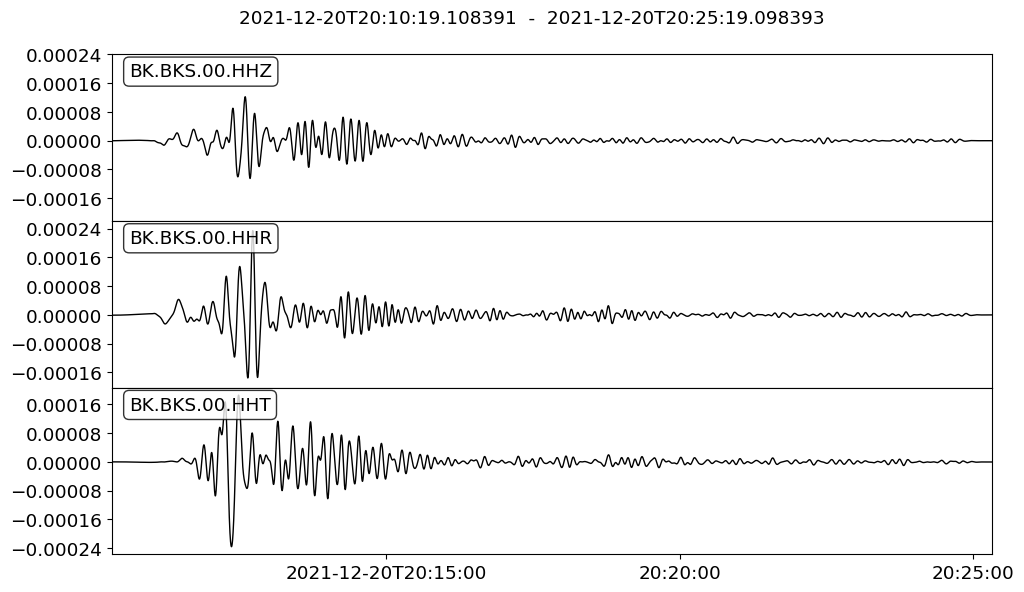

In [200]:
baz1 = get_baz(st1, inv1, evla, evlo)
st1_zrt = st1_zne.copy()
st1_zrt.rotate(method='NE->RT',back_azimuth=baz1[2])
if plotOPT:
    _plot = st1_zrt.plot(size=(1000,600))

Epicentral distance [m]:  345940.20040773024
Epicentral distance [km]:  345.94020040773023
Theoretical azimuth [deg]:  140.6740274863965
Theoretical backazimuth [deg]:  322.24564704631103


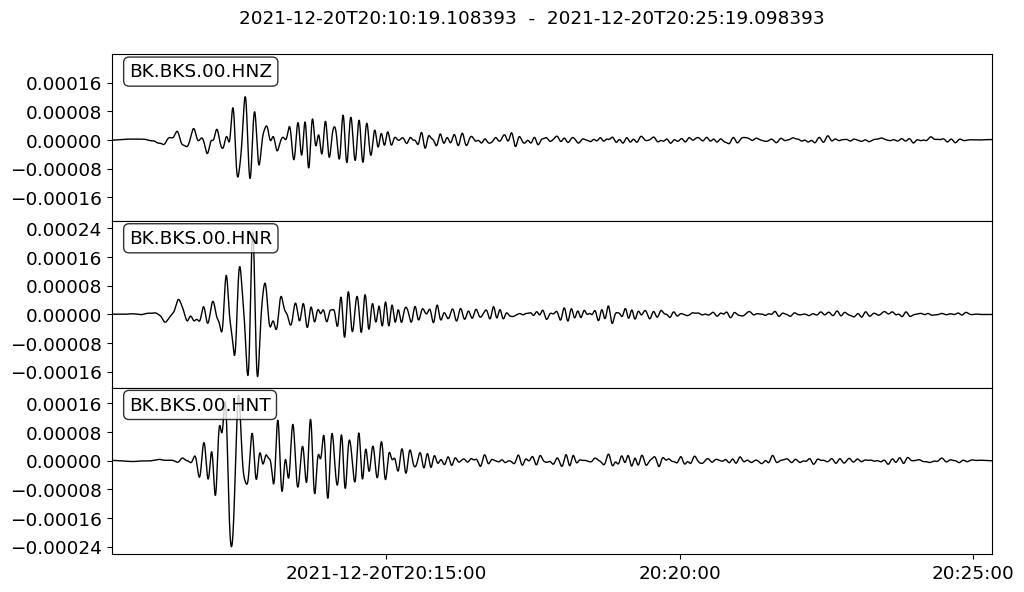

In [201]:
baz2 = get_baz(st2, inv2, evla, evlo)
st2_zrt = st2_zne.copy()
st2_zrt.rotate(method='NE->RT',back_azimuth=baz2[2])
if plotOPT:
    _plot = st2_zrt.plot(size=(1000,600))

## Combining all streams
st_all includ all ZNERT data from two stations

In [202]:
#st1_zne
#st2_zrt

In [203]:
#st1_zrt


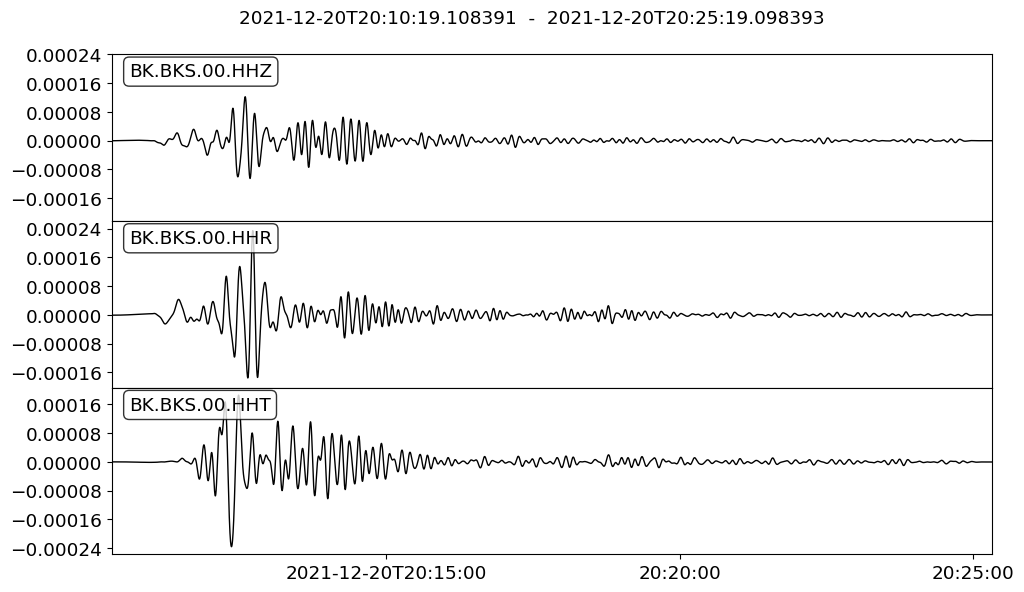

In [204]:
if plotOPT:
    _plot = st1_zrt.plot(size=(1000,600))

In [205]:
#st_all = st2_zrt.copy() + st1_zrt.copy()
# def
st_all = st2_zrt.copy() + st2_zne.select(component="E")  + st2_zne.select(component="N")  + st1_zrt.copy() + st1_zne.select(component="E") + st1_zne.select(component="N")


#st_all = st2_zrt.copy() + st2_zne.select(component="3")  + st2_zne.select(component="2")  + st1_zrt.copy() + st1_zne.select(component="3") + st1_zne.select(component="2")
#st_all =  st2_zne.select(component="E")  + st2_zne.select(component="N") + st2_zne.select(component="Z")  + st1_zne.select(component="E") + st1_zne.select(component="N") + st1_zne.select(component="Z")


In [206]:
print(st_all)

10 Trace(s) in Stream:
BK.BKS.00.HNT | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNR | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNE | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HNN | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHT | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHR | 2021-12-20T20:10:19.108391Z - 2021-12-20T20:25:19.098391Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHZ | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHE | 2021-12-20T20:10:19.108393Z - 2021-12-20T20:25:19.098393Z | 100.0 Hz, 90000 samples
BK.BKS.00.HHN | 2021-12-20T20:10:19.108391Z - 2021-12-20T20:25:19.098391Z | 1

In [207]:
#st_all = st2_zrt.select(component="T") + st1.select(component="3")
#st_all =  st1.select(component="2")
#st_all = st2_zrt.select(component="T") + st1.select(station="SMNB", component="3") + st1.select(station="CCRB", component="3") + st1.select(station="MMNB", component="3") + st1.select(station="SCYB", component="3") + st1.select(station="VCAB", component="3") + st1.select(station="LCCB", component="3")


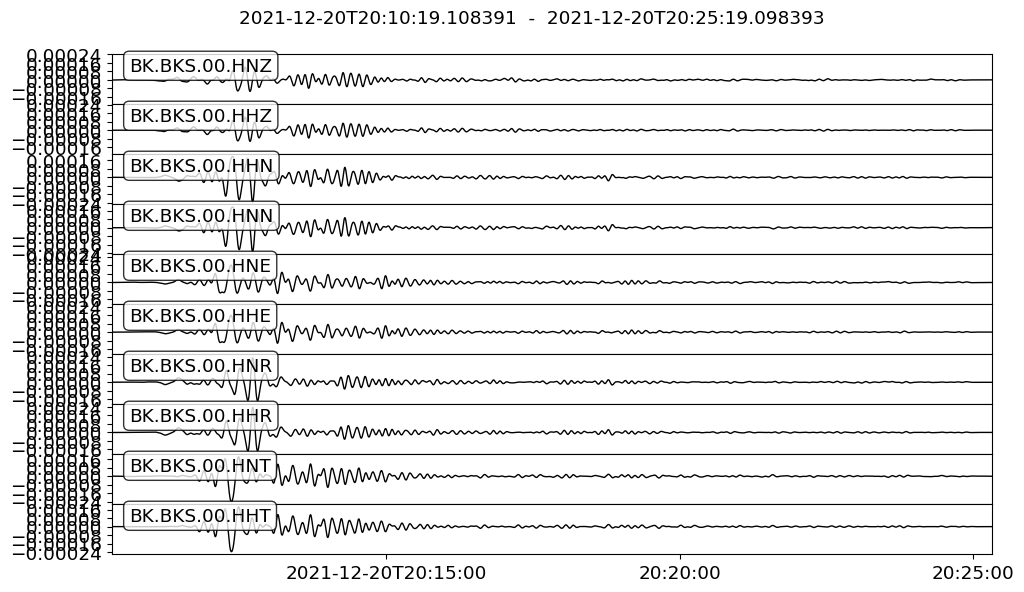

In [208]:
if plotOPT:
    _plot = st_all.plot(size=(1000,600))

## Computing arrival time of Rayleigh wave
event ditance / Rvel (This example uses 4.2 km/s)

In [209]:
 baz2[0]

345940.20040773024

In [210]:
Rwave_arrival = baz2[0]/1000.0/Rvel
print("# Rwave_arrival = ",Rwave_arrival)

# Rwave_arrival =  82.3667143827929


## Trim seismic data


In [211]:
#tw_trim/60

In [212]:
#tw_start = origin_time + Rwave_arrival + tw_pre_tw - 60
#tw_end = tw_start + tw_trim - 60 -60 -30

# def
tw_start = origin_time + Rwave_arrival + tw_pre_tw 

#tw_start = origin_time + 20 + tw_pre_tw 

tw_end = tw_start + tw_trim

#tw_end = tw_start + 60

print(tw_start, tw_end)
#st_select.trim(dt, dt + tw_trim)  

2021-12-20T20:03:21.466714Z 2021-12-20T20:31:41.466714Z


In [213]:
print("# tw_start  =", tw_start )
print("# tw_end.   =", tw_end )

# tw_start  = 2021-12-20T20:03:21.466714Z
# tw_end.   = 2021-12-20T20:31:41.466714Z


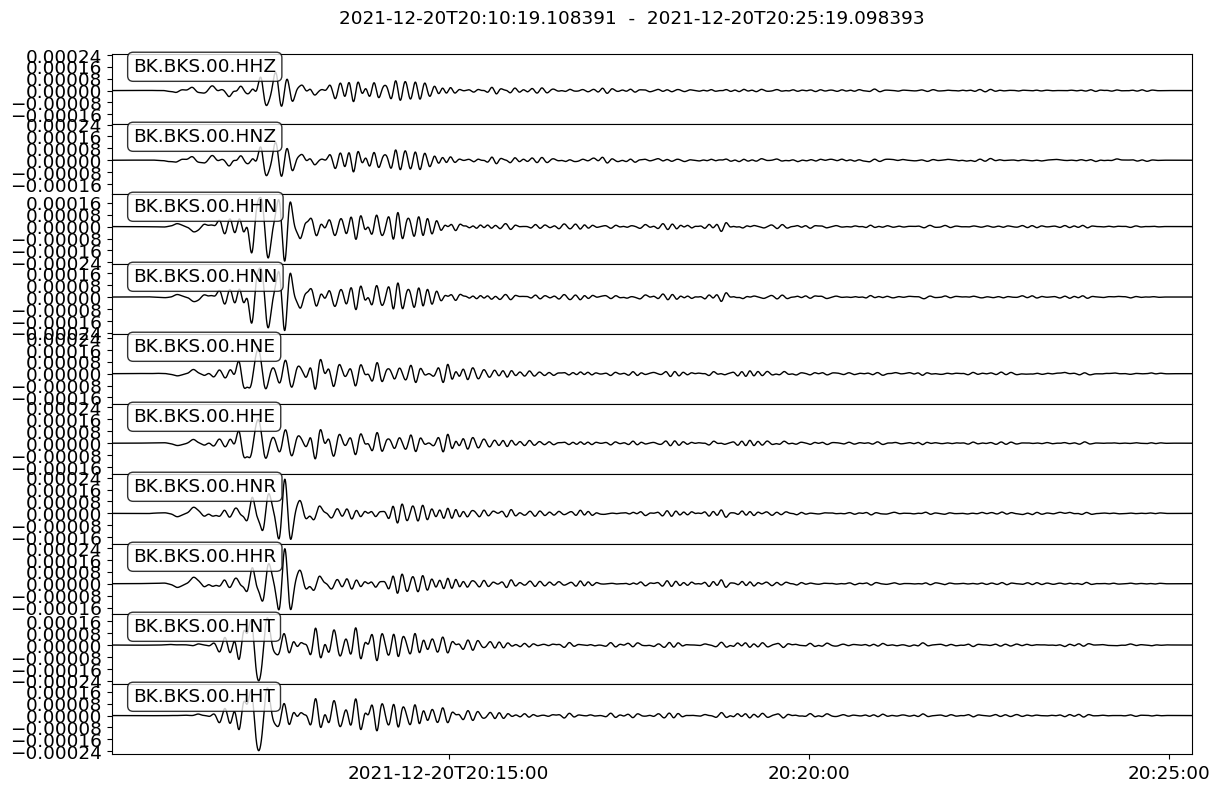

In [214]:
notrimOPT = 0

if notrimOPT:
    print("# no trime")
else:
    if manualOPT:
        print("# no trime")
    else:
        st_all.trim(tw_start, tw_end)  

    
st_all.detrend('linear') # remove linear trend
st_all.detrend("demean") # demean
st_all.taper(0.05)
if plotOPT:
    _plot = st_all.plot(size=(1200,800))

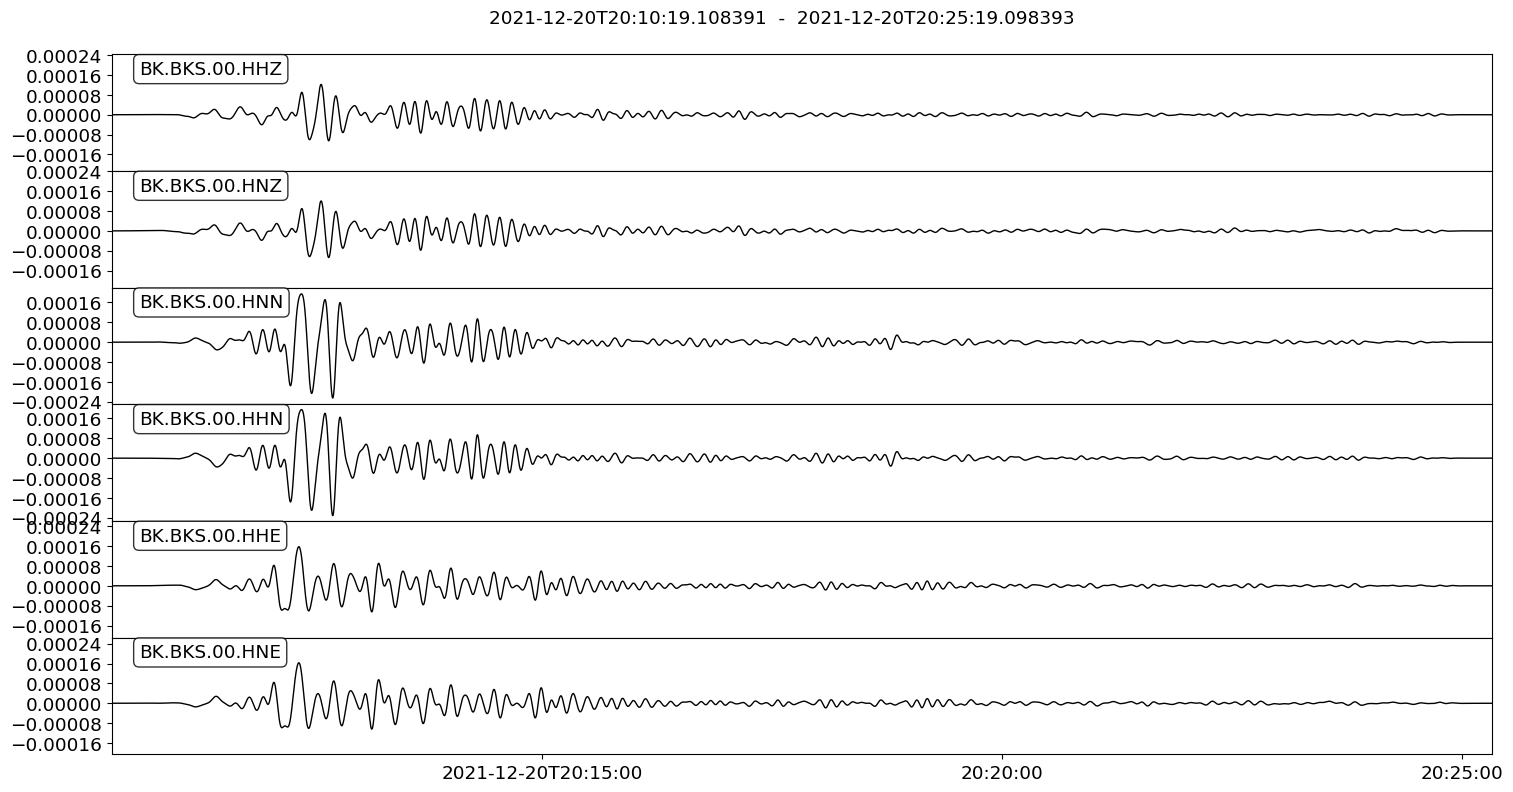

In [215]:
if plotOPT:
    st_tmp =  st2_zne.select(component="Z")  + st2_zne.select(component="E")  + st2_zne.select(component="N")  + st1_zne.select(component="Z") + st1_zne.select(component="E") + st1_zne.select(component="N")
    
    
    if notrimOPT:
        print("# no trime")
    else:
        if manualOPT:
            print("# no trime")
        else:
            st_tmp.trim(tw_start, tw_end)  

    st_tmp.detrend('linear') # remove linear trend
    st_tmp.detrend("demean") # demean
    st_tmp.taper(0.05)
    _plot = st_tmp.plot(size=(1500,800))
    #_plot = st_tmp.plot(size=(1500,800),equal_scale=False)


## Waveform similarity 
This example will use transverse component data

#RESULT cc_pearsonr_out =  0.993   BK.BKS.00.HNZ   BK.BKS.00.HHZ
#RESULT distkm1_out =  345.940   BK.BKS.00.HNZ   BK.BKS.00.HHZ
#RESULT distkm2_out =  345.940   BK.BKS.00.HNZ   BK.BKS.00.HHZ
#RESULT amp_median_out =  0.989  amp_l1_out =  0.150   BK.BKS.00.HNZ   BK.BKS.00.HHZ
#RESULT ph_median_out =  -0.006  ph_l1_out =  0.231   BK.BKS.00.HNZ   BK.BKS.00.HHZ
#RESULT2  BK.BKS.00.HNZ   BK.BKS.00.HHZ   0.989   0.150   -0.006   0.231   0.993


<ipython-input-149-672b1f473389>:318: RuntimeWarning: invalid value encountered in true_divide
  delay_sec = (yf_ph_diff[0:N1//2])/(2*np.pi*xf1)


#RESULT cc_pearsonr_out =  0.998   BK.BKS.00.HNN   BK.BKS.00.HHN
#RESULT distkm1_out =  345.940   BK.BKS.00.HNN   BK.BKS.00.HHN
#RESULT distkm2_out =  345.940   BK.BKS.00.HNN   BK.BKS.00.HHN
#RESULT amp_median_out =  1.021  amp_l1_out =  0.078   BK.BKS.00.HNN   BK.BKS.00.HHN
#RESULT ph_median_out =  -0.003  ph_l1_out =  0.060   BK.BKS.00.HNN   BK.BKS.00.HHN
#RESULT2  BK.BKS.00.HNN   BK.BKS.00.HHN   1.021   0.078   -0.003   0.060   0.998


<ipython-input-149-672b1f473389>:318: RuntimeWarning: divide by zero encountered in true_divide
  delay_sec = (yf_ph_diff[0:N1//2])/(2*np.pi*xf1)


#RESULT cc_pearsonr_out =  0.997   BK.BKS.00.HNE   BK.BKS.00.HHE
#RESULT distkm1_out =  345.940   BK.BKS.00.HNE   BK.BKS.00.HHE
#RESULT distkm2_out =  345.940   BK.BKS.00.HNE   BK.BKS.00.HHE
#RESULT amp_median_out =  0.977  amp_l1_out =  0.095   BK.BKS.00.HNE   BK.BKS.00.HHE
#RESULT ph_median_out =  -0.013  ph_l1_out =  0.112   BK.BKS.00.HNE   BK.BKS.00.HHE
#RESULT2  BK.BKS.00.HNE   BK.BKS.00.HHE   0.977   0.095   -0.013   0.112   0.997


<ipython-input-149-672b1f473389>:318: RuntimeWarning: invalid value encountered in true_divide
  delay_sec = (yf_ph_diff[0:N1//2])/(2*np.pi*xf1)


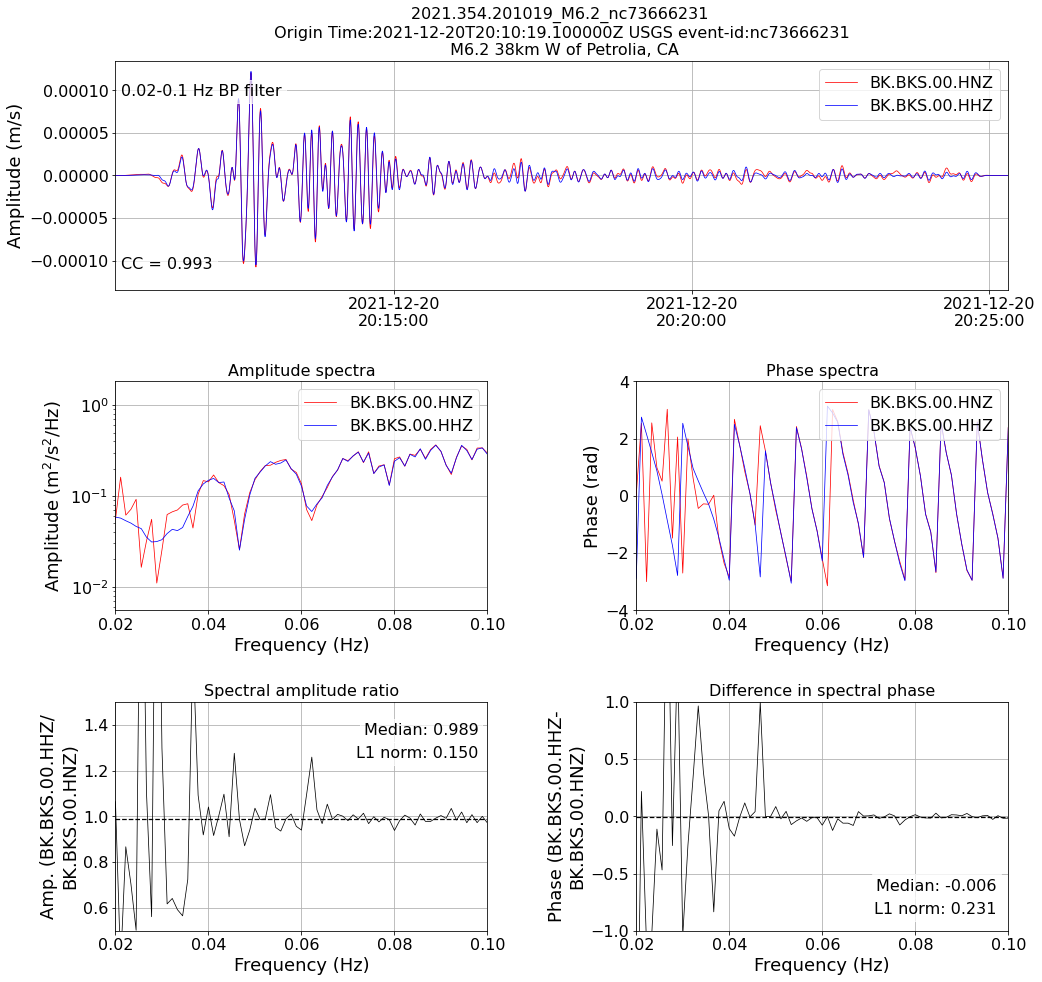

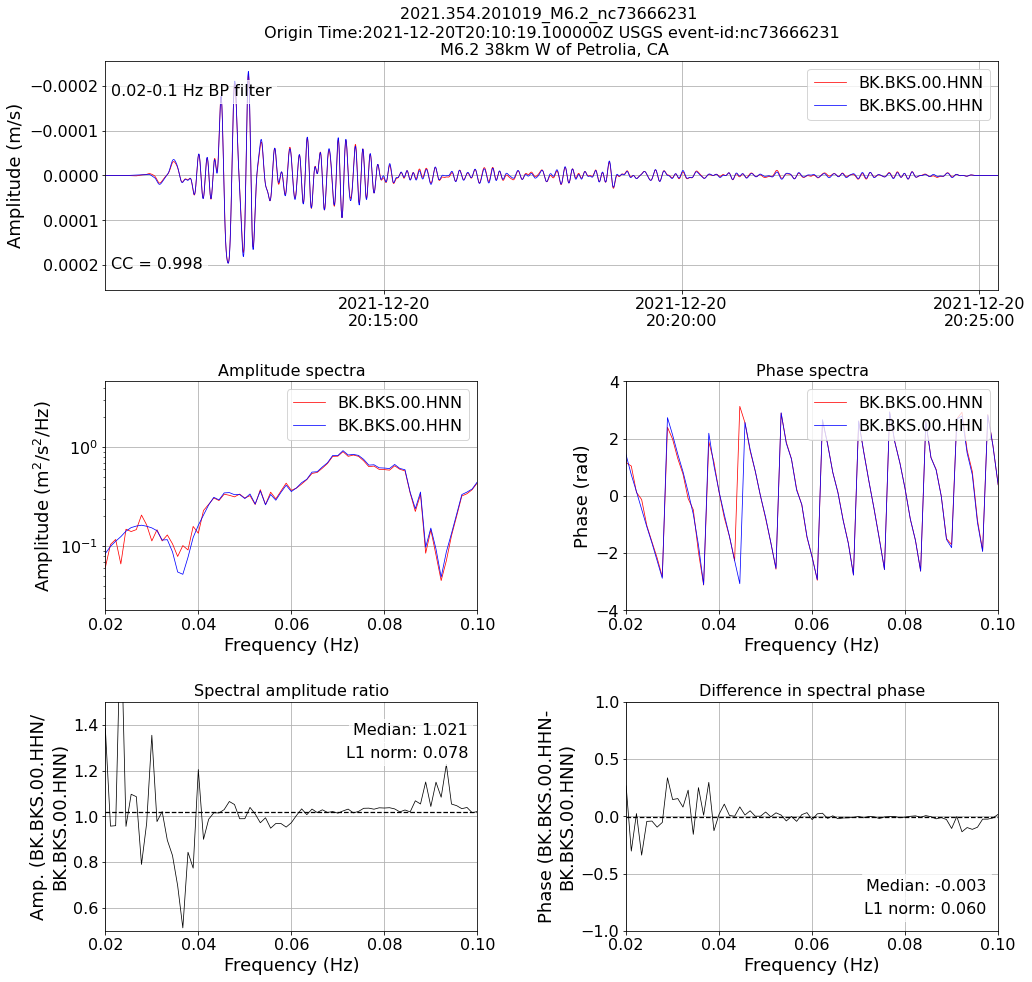

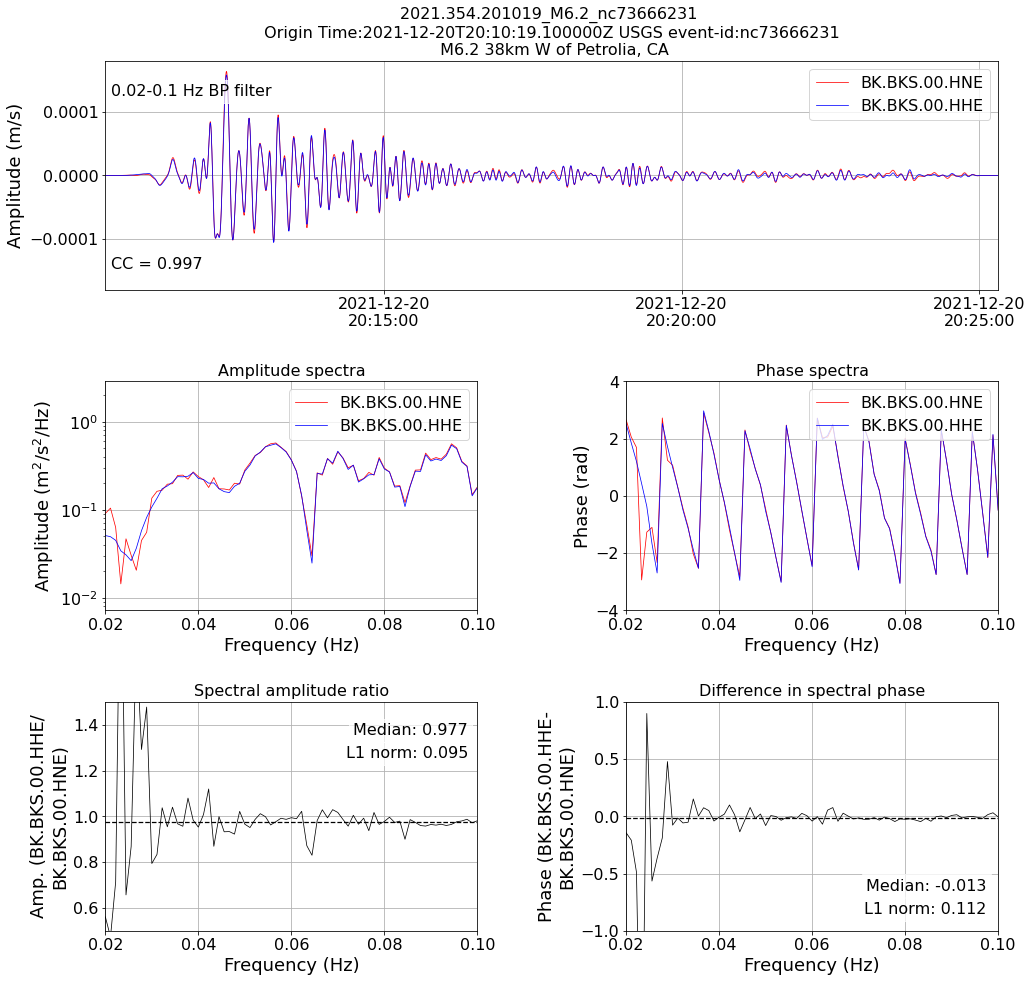

In [217]:
#select_channel = "Z"
# def
#select_channel = ["N", "E" , "T", "R", "Z" ]
#select_channel = ["Z", "T", "R"]
select_channel = ["Z", "N", "E"]
#select_channel = ["Z"]

#slideOPT = 1
slideOPT = 0

for component in select_channel:
    st_select = st_all.select(component=component) 
    #waveform_comparison(st_select, 1, slideOPT)

    try:
        waveform_comparison(st_select, 1, slideOPT, logOPT, manualOPT)
        #waveform_comparison(st_select, 0)

    except:
        print("# no data: "+component)

    #print(st_select)
    
    